# An√°lise Explorat√≥ria de Pre√ßos de Combust√≠veis e Vari√°veis Macroecon√¥micas


# Introdu√ß√£o

Os pre√ßos dos combust√≠veis afetam diretamente a economia, influenciando o custo do transporte, log√≠stica e infla√ß√£o.  
Este estudo visa desenvolver um modelo preditivo para antecipar varia√ß√µes e auxiliar na tomada de decis√µes estrat√©gicas.

A seguir, exploramos os dados hist√≥ricos, identificamos padr√µes e aplicamos modelos de Machine Learning para prever os pre√ßos dos combust√≠veis no Brasil.


## Objetivos:
- Identificar padr√µes sazonais e regionais nos pre√ßos dos combust√≠veis.
- Analisar correla√ß√µes com vari√°veis macroecon√¥micas, como c√¢mbio e infla√ß√£o.
- Preparar os dados para modelagem preditiva.

---


# Coleta de Dados

Os dados foram coletados a partir das seguintes fontes:

- **ANP (Ag√™ncia Nacional do Petr√≥leo, G√°s Natural e Biocombust√≠veis)** - pre√ßos de revenda.
- **Banco Central e IBGE** - vari√°veis macroecon√¥micas (infla√ß√£o, c√¢mbio, PIB).
- **Outras fontes econ√¥micas** - eventos que impactam o setor de combust√≠veis.

### Processamento Inicial:
- Remo√ß√£o de valores ausentes e inconsistentes.
- Convers√£o de formatos de data e pre√ßos.
- Identifica√ß√£o de outliers e poss√≠veis ajustes.

---


Este notebook realiza uma **an√°lise explorat√≥ria completa** dos pre√ßos dos combust√≠veis e sua rela√ß√£o com vari√°veis macroecon√¥micas. Tamb√©m analisamos quais colunas devem ser mantidas ou removidas, utilizando **estat√≠sticas descritivas, gr√°ficos e testes estat√≠sticos**.

In [1]:
# Vers√£o da Linguagem Python
from platform import python_version
print('Vers√£o da Linguagem Python Usada Neste Jupyter Notebook: ', python_version())

Vers√£o da Linguagem Python Usada Neste Jupyter Notebook:  3.12.1


# 0.0. Importando

In [2]:
# Importa√ß√£o de Bibliotecas
import os
import re
import io
import pickle
import joblib
import warnings
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from pathlib import Path
from IPython.core.display import display, HTML
from boruta import BorutaPy

from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit, 
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OneHotEncoder, 
    LabelEncoder, 
    RobustScaler, 
    MinMaxScaler, 
    StandardScaler
)
from xgboost import XGBRegressor

# Configura√ß√£o de estilo dos gr√°ficos
sns.set_style("whitegrid")


c:\Users\sydne\OneDrive\Pessoal\workspace\fuel_price_predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sydne\AppData\Local\Temp\ipykernel_27292\51664525.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


## 0.1. Helper Functions

In [3]:
from turtle import title

warnings.filterwarnings('ignore')

def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 13]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    sns.set()


# Fun√ß√£o para calcular m√©tricas de erro dos modelos
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE': [mae],
        'RMSE': [rmse]
    })


# Fun√ß√£o para treinar e avaliar um modelo
def avaliar_modelo(features, nome_modelo):
    df_model = df_final_00.dropna(subset=features + ['valor_de_venda'])
    X = df_model[features]
    y = df_model['valor_de_venda']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    results = {
        'Modelo': nome_modelo,
        'R¬≤ Treino': r2_score(y_train, y_pred_train),
        'R¬≤ Teste': r2_score(y_test, y_pred_test),
        'RMSE Treino': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE Teste': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE Treino': mean_absolute_error(y_train, y_pred_train),
        'MAE Teste': mean_absolute_error(y_test, y_pred_test)
    }
    
    return results


# Fun√ß√£o para calcular o Erro Percentual M√©dio (MPE)
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


# Fun√ß√£o para transformar os nomes
def renomear_coluna(nome):
    nome = nome.lower()  # Converte para min√∫sculas
    nome = re.sub(r'[^a-z0-9]+', '_', nome)  # Substitui espa√ßos e caracteres especiais por "_"
    nome = nome.strip('_')  # Remove "_" extras no in√≠cio ou fim
    return nome


def analisar_colunas_vazias(df):
    """
    Analisa um DataFrame e retorna um relat√≥rio sobre colunas com valores ausentes,
    colunas completamente vazias e a porcentagem de valores nulos.

    Par√¢metros:
    df (pd.DataFrame): DataFrame a ser analisado.

    Retorno:
    pd.DataFrame: DataFrame com o relat√≥rio de an√°lise.
    """
    # Contagem de valores nulos
    nulos = df.isnull().sum()

    # Porcentagem de valores nulos
    porcentagem_nulos = (nulos / len(df)) * 100

    # Colunas completamente vazias (todas as linhas s√£o NaN)
    colunas_totalmente_vazias = df.columns[df.isnull().all()].tolist()

    # Colunas que possuem pelo menos um valor nulo
    colunas_parcialmente_vazias = df.columns[df.isnull().any()].tolist()

    # Colunas que t√™m apenas um √∫nico valor (pode ser um indicativo de irrelev√¢ncia)
    colunas_unicas = df.nunique()
    colunas_constantes = colunas_unicas[colunas_unicas == 1].index.tolist()

    # Criando um DataFrame com o relat√≥rio
    relatorio = pd.DataFrame({
        'Coluna': df.columns,
        'Valores Nulos': nulos.values,
        'Porcentagem de Nulos (%)': porcentagem_nulos.values,
        '100% Vazia': df.columns.isin(colunas_totalmente_vazias),
        'Possui Nulos': df.columns.isin(colunas_parcialmente_vazias),
        'Valor √önico (Poss√≠vel Constante)': df.columns.isin(colunas_constantes)
    })

    return relatorio


def analisar_qualidade_dados(df):
    """
    Analisa a qualidade dos dados em um DataFrame, verificando:
    - Strings vazias ("") e espa√ßos (" ")
    - Linhas duplicadas
    - Distribui√ß√£o dos valores √∫nicos por coluna

    Par√¢metros:
    df (pd.DataFrame): DataFrame a ser analisado.

    Retorno:
    pd.DataFrame: DataFrame com o relat√≥rio de an√°lise.
    """
    # Contagem de strings vazias ("") e espa√ßos em branco (" ")
    vazios = (df == "").sum()
    espacos = (df == " ").sum()

    # Contagem de valores √∫nicos por coluna
    valores_unicos = df.nunique()

    # Verificar a quantidade de linhas duplicadas no DataFrame
    linhas_duplicadas = df.duplicated().sum()

    # Criando um DataFrame com o relat√≥rio
    relatorio = pd.DataFrame({
        'Coluna': df.columns,
        'Valores Vazios ("")': vazios.values,
        'Espa√ßos em Branco (" ")': espacos.values,
        'Valores √önicos': valores_unicos.values
    })

    print(f"Linhas Duplicadas no DataFrame: {linhas_duplicadas}")

    return relatorio


# Criar fun√ß√£o para calcular os estat√≠sticos
def resumo_boxplot(df, group_col):
    return df.groupby(group_col)['valor_de_venda'].agg(
        Minimo='min',
        Q1=lambda x: x.quantile(0.25),
        Mediana='median',
        Q3=lambda x: x.quantile(0.75),
        Maximo='max',
        Media='mean',
        Desvio_Padrao='std'
    ).reset_index()


def analisar_distribuicao_precos_por_produto(df, coluna_preco='valor_de_venda', coluna_produto='produto'):
    """
    Gera um gr√°fico de distribui√ß√£o (histograma + KDE) e uma tabela de frequ√™ncia para an√°lise dos pre√ßos dos combust√≠veis.

    Par√¢metros:
    - df: DataFrame contendo os dados.
    - coluna_preco: Nome da coluna que cont√©m os pre√ßos dos combust√≠veis.
    - coluna_produto: Nome da coluna que cont√©m os tipos de combust√≠veis.
    - titulo: T√≠tulo do gr√°fico.

    Retorno:
    - Exibe o gr√°fico de distribui√ß√£o dos pre√ßos.
    - Exibe uma tabela de frequ√™ncia das faixas de pre√ßos.
    """
    # Criar o gr√°fico de distribui√ß√£o dos pre√ßos por tipo de combust√≠vel

    # Criar um gr√°fico de distribui√ß√£o para cada tipo de combust√≠vel
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='valor_de_venda', hue='produto', bins=30, kde=True)

    # Adicionar t√≠tulo e labels
    plt.title('Distribui√ß√£o dos Pre√ßos dos Combust√≠veis (Apenas 2023-2024)')
    plt.xlabel('Pre√ßo de Venda (R$)')
    plt.ylabel('Frequ√™ncia')

    # Mostrar o gr√°fico
    plt.show()

    # Definir os intervalos de pre√ßos
    bins = np.arange(df[coluna_preco].min(), df[coluna_preco].max() + 0.5, 0.5)  # Intervalos de 0.50 reais
    labels = [f"{round(bins[i],2)} - {round(bins[i+1],2)}" for i in range(len(bins)-1)]

    # Criar DataFrame para armazenar os resultados
    tabela_frequencia = pd.DataFrame()

    # Loop por cada produto e calcular frequ√™ncia
    for produto in df[coluna_produto].unique():
        df_produto = df[df[coluna_produto] == produto].copy()
        df_produto['Faixa_Preco'] = pd.cut(df_produto[coluna_preco], bins=bins, labels=labels, include_lowest=True)
        freq_produto = df_produto['Faixa_Preco'].value_counts().sort_index().reset_index()
        freq_produto.columns = ['Faixa de Pre√ßo (R$)', f'Frequ√™ncia ({produto})']

        # Converter 'Faixa de Pre√ßo (R$)' para string para evitar erro do Pandas
        freq_produto['Faixa de Pre√ßo (R$)'] = freq_produto['Faixa de Pre√ßo (R$)'].astype(str)

        # Juntar os resultados na tabela final
        if tabela_frequencia.empty:
            tabela_frequencia = freq_produto
        else:
            tabela_frequencia = tabela_frequencia.merge(freq_produto, on="Faixa de Pre√ßo (R$)", how="outer")

    # Preencher valores nulos com zero e converter colunas num√©ricas para inteiros
    tabela_frequencia = tabela_frequencia.fillna(0)
    for col in tabela_frequencia.columns[1:]:  # Evita converter a coluna de faixa de pre√ßo
        tabela_frequencia[col] = tabela_frequencia[col].astype(int)

    # Exibir a tabela interativa
    display(tabela_frequencia)

    

In [4]:
jupyter_settings()

# Criar diret√≥rio se n√£o existir
model_dir = "../data/models/"
os.makedirs(model_dir, exist_ok=True)

## 0.2. Carregamento dos Dados

In [5]:
# Caminho para o diret√≥rio acima do atual
BASE_DIR = Path("..")  # Sobe um n√≠vel na hierarquia de diret√≥rios

# Caminho para o diret√≥rio "data/processed/" dentro do diret√≥rio acima
DATA_DIR = BASE_DIR / "data" / "processed"

# Definir os caminhos dos arquivos
file_paths = {
    "macroeconomic_data": DATA_DIR / "macroeconomic_data.csv",
    "precos_combustiveis_unificado": DATA_DIR / "precos_combustiveis_unificado.csv",
}

# Carregar os datasets
dfs = {name: pd.read_csv(path, encoding="utf-8", delimiter=",") for name, path in file_paths.items()}

# Separar os datasets
df_macro = dfs["macroeconomic_data"]
df_combustiveis = dfs["precos_combustiveis_unificado"]

--- 
# Dicion√°rio de Dados

##  Valor de Venda dos Combust√≠veis

| Nome da Coluna           | Tipo de Dado  | Descri√ß√£o |
|--------------------------|--------------|-----------|
| **Regiao - Sigla**       | String (2)   | Sigla da regi√£o do Brasil onde a revenda est√° localizada. |
| **Estado - Sigla**       | String (2)   | Sigla da unidade federativa (UF) onde a revenda est√° localizada. |
| **Municipio**            | String       | Nome do munic√≠pio onde a revenda est√° localizada. |
| **Revenda**              | String       | Nome da revenda de combust√≠veis. |
| **CNPJ da Revenda**      | String (18)  | Cadastro Nacional da Pessoa Jur√≠dica (CNPJ) da revenda. |
| **Nome da Rua**          | String       | Nome da rua onde a revenda est√° localizada. |
| **Numero Rua**           | String       | N√∫mero do endere√ßo da revenda. Caso n√£o tenha n√∫mero, pode aparecer como "S/N". |
| **Bairro**              | String       | Nome do bairro onde a revenda est√° localizada. |
| **Cep**                 | String (9)   | C√≥digo de Endere√ßamento Postal (CEP) da revenda. |
| **Produto**             | String       | Tipo de combust√≠vel vendido (Ex: Gasolina, Etanol, Diesel, etc.). |
| **Data da Coleta**      | Data (YYYY-MM-DD) | Data em que os pre√ßos foram coletados. |
| **Valor de Venda**      | Float        | Pre√ßo do combust√≠vel no dia da coleta. |
| **Unidade de Medida**   | String       | Unidade de medida do combust√≠vel (exemplo: "R$ / litro"). |
| **Bandeira**           | String       | Nome da bandeira/distribuidora da revenda (Ex: "BRANCA", "VIBRA ENERGIA", etc.). |

**Observa√ß√µes:**
- A coluna `CNPJ da Revenda` segue o formato `XX.XXX.XXX/XXXX-XX`.
- A coluna `Numero Rua` pode conter valores num√©ricos ou `S/N` caso o n√∫mero n√£o seja informado.
- A `Bandeira` indica se a revenda √© de marca pr√≥pria ("BRANCA") ou vinculada a uma distribuidora espec√≠fica.
- A `Data da Coleta` est√° no formato `YYYY-MM-DD` para facilitar an√°lises temporais.



## Indicadores Econ√¥micos

| Nome da Coluna  | Tipo de Dado  | Descri√ß√£o |
|-----------------|--------------|-----------|
| **date**        | Data (YYYY-MM-DD) | Data correspondente √†s informa√ß√µes econ√¥micas. |
| **taxa_usd**    | Float        | Taxa de c√¢mbio do d√≥lar (USD) em rela√ß√£o ao real (BRL) na data informada. |
| **ipca**        | Float        | √çndice de Pre√ßos ao Consumidor Amplo (IPCA), que mede a infla√ß√£o oficial do Brasil. Representado como percentual mensal. |
| **brent_price** | Float        | Pre√ßo do barril de petr√≥leo tipo Brent (em d√≥lares) na data correspondente. |
| **wti_price**   | Float        | Pre√ßo do barril de petr√≥leo tipo WTI (West Texas Intermediate) (em d√≥lares) na data correspondente. |
| **selic**       | Float        | Taxa Selic, taxa b√°sica de juros do Brasil, vigente na data informada. |

**Observa√ß√µes:**
- A coluna `date` est√° no formato `YYYY-MM-DD` para facilitar an√°lises temporais.
- A `taxa_usd` representa o valor do c√¢mbio do d√≥lar no dia correspondente.
- O `ipca` √© um √≠ndice percentual mensal que mede a infla√ß√£o oficial.
- Os pre√ßos de petr√≥leo (`brent_price` e `wti_price`) est√£o em d√≥lares americanos por barril.
- A taxa `selic` √© expressa em percentual anual e influencia diretamente os juros da economia.



In [6]:
# !pip install watermark

In [7]:
# Vers√µes dos pacotes usados
%reload_ext watermark
%watermark -a "Sidney Martins Neto" --iversion

Author: Sidney Martins Neto

joblib     : 1.4.2
statsmodels: 0.14.4
re         : 2.2.1
platform   : 1.0.8
matplotlib : 3.10.0
IPython    : 8.31.0
seaborn    : 0.13.2
shap       : 0.47.0
xgboost    : 2.1.4
sklearn    : 1.6.0
pandas     : 2.2.3
scipy      : 1.14.1
boruta     : 0.4.3
numpy      : 2.1.0



---
# 1.0. Analisando as Colunas Antes da Limpeza

In [8]:
df1_combustiveis = df_combustiveis.copy()

## 1.1. Dados dos Combust√≠veis

In [9]:
df1_combustiveis.head()

Regiao - Sigla Estado - Sigla  Municipio  \
0             SE             SP   SOROCABA   
1             SE             SP   SOROCABA   
2             NE             AL  ARAPIRACA   
3             NE             AL  ARAPIRACA   
4             NE             AL  ARAPIRACA   

                                             Revenda      CNPJ da Revenda  \
0  COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...   00.003.188/0001-21   
1  COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...   00.003.188/0001-21   
2  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   
3  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   
4  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   

              Nome da Rua Numero Rua          Bairro        Cep   Produto  \
0  RUA HUMBERTO DE CAMPOS        306  JARDIM ZULMIRA  18061-000    ETANOL   
1  RUA HUMBERTO DE CAMPOS        306  JARDIM ZULMIRA  18061-000  GASOLINA   
2  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000    ETANOL   
3  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000    DIESEL   
4  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000  GASOLINA   

  Data da Coleta  Valor de Venda Unidade de Medida       Bandeira  
0     2023-01-03          3.3900        R$ / litro         BRANCA  
1     2023-01-03          4.3900        R$ / litro         BRANCA  
2     2023-01-02          3.8900        R$ / litro  VIBRA ENERGIA  
3     2023-01-02          6.4900        R$ / litro  VIBRA ENERGIA  
4     2023-01-02          5.1400        R$ / litro  VIBRA ENERGIA

### 1.1. Rename Columns

In [10]:
# Lista de colunas original
colunas_antigas = df1_combustiveis.columns.to_list()

# Aplicando a transforma√ß√£o
colunas_novas = [renomear_coluna(col) for col in colunas_antigas]

# Criando um dicion√°rio de mapeamento
mapeamento = dict(zip(colunas_antigas, colunas_novas))

# Exibindo o resultado
display(mapeamento)

df1_combustiveis = df1_combustiveis.rename(columns=mapeamento)


{'Regiao - Sigla': 'regiao_sigla',
 'Estado - Sigla': 'estado_sigla',
 'Municipio': 'municipio',
 'Revenda': 'revenda',
 'CNPJ da Revenda': 'cnpj_da_revenda',
 'Nome da Rua': 'nome_da_rua',
 'Numero Rua': 'numero_rua',
 'Bairro': 'bairro',
 'Cep': 'cep',
 'Produto': 'produto',
 'Data da Coleta': 'data_da_coleta',
 'Valor de Venda': 'valor_de_venda',
 'Unidade de Medida': 'unidade_de_medida',
 'Bandeira': 'bandeira'}

In [11]:
display(df1_combustiveis.head())

regiao_sigla estado_sigla  municipio  \
0           SE           SP   SOROCABA   
1           SE           SP   SOROCABA   
2           NE           AL  ARAPIRACA   
3           NE           AL  ARAPIRACA   
4           NE           AL  ARAPIRACA   

                                             revenda      cnpj_da_revenda  \
0  COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...   00.003.188/0001-21   
1  COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...   00.003.188/0001-21   
2  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   
3  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   
4  COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...   02.817.655/0001-82   

              nome_da_rua numero_rua          bairro        cep   produto  \
0  RUA HUMBERTO DE CAMPOS        306  JARDIM ZULMIRA  18061-000    ETANOL   
1  RUA HUMBERTO DE CAMPOS        306  JARDIM ZULMIRA  18061-000  GASOLINA   
2  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000    ETANOL   
3  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000    DIESEL   
4  RODOVIA AL 220 - KM 06        S/N        PLANALTO  57308-000  GASOLINA   

  data_da_coleta  valor_de_venda unidade_de_medida       bandeira  
0     2023-01-03          3.3900        R$ / litro         BRANCA  
1     2023-01-03          4.3900        R$ / litro         BRANCA  
2     2023-01-02          3.8900        R$ / litro  VIBRA ENERGIA  
3     2023-01-02          6.4900        R$ / litro  VIBRA ENERGIA  
4     2023-01-02          5.1400        R$ / litro  VIBRA ENERGIA

## 1.2. Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format(df1_combustiveis.shape[0]) )
print( 'Number of Cols: {}'.format(df1_combustiveis.shape[1]) )

Number of Rows: 1068977
Number of Cols: 14


## 1.3. Data Types

In [13]:
df1_combustiveis['data_da_coleta'] = pd.to_datetime( df1_combustiveis['data_da_coleta'] )
df1_combustiveis.dtypes

regiao_sigla                 object
estado_sigla                 object
municipio                    object
revenda                      object
cnpj_da_revenda              object
nome_da_rua                  object
numero_rua                   object
bairro                       object
cep                          object
produto                      object
data_da_coleta       datetime64[ns]
valor_de_venda              float64
unidade_de_medida            object
bandeira                     object
dtype: object

## 1.4. Check NA

In [14]:
analisar_colunas_vazias(df1_combustiveis)

Coluna  Valores Nulos  Porcentagem de Nulos (%)  100% Vazia  \
0        regiao_sigla              0                    0.0000       False   
1        estado_sigla              0                    0.0000       False   
2           municipio              0                    0.0000       False   
3             revenda              0                    0.0000       False   
4     cnpj_da_revenda              0                    0.0000       False   
5         nome_da_rua              0                    0.0000       False   
6          numero_rua              0                    0.0000       False   
7              bairro              0                    0.0000       False   
8                 cep              0                    0.0000       False   
9             produto              0                    0.0000       False   
10     data_da_coleta              0                    0.0000       False   
11     valor_de_venda              0                    0.0000       False   
12  unidade_de_medida              0                    0.0000       False   
13           bandeira              0                    0.0000       False   

    Possui Nulos  Valor √önico (Poss√≠vel Constante)  
0          False                             False  
1          False                             False  
2          False                             False  
3          False                             False  
4          False                             False  
5          False                             False  
6          False                             False  
7          False                             False  
8          False                             False  
9          False                             False  
10         False                             False  
11         False                             False  
12         False                              True  
13         False                             False

In [15]:
analisar_qualidade_dados(df1_combustiveis)

Linhas Duplicadas no DataFrame: 4


Coluna  Valores Vazios ("")  Espa√ßos em Branco (" ")  \
0        regiao_sigla                    0                        0   
1        estado_sigla                    0                        0   
2           municipio                    0                        0   
3             revenda                    0                        0   
4     cnpj_da_revenda                    0                        0   
5         nome_da_rua                    0                        0   
6          numero_rua                    0                        0   
7              bairro                    0                        0   
8                 cep                    0                        0   
9             produto                    0                        0   
10     data_da_coleta                    0                        0   
11     valor_de_venda                    0                        0   
12  unidade_de_medida                    0                        0   
13           bandeira                    0                        0   

    Valores √önicos  
0                5  
1               27  
2              460  
3            11041  
4            12440  
5             7833  
6             4053  
7             5292  
8             9326  
9                3  
10             529  
11             525  
12               1  
13              54

## 1.5. Fillout NA 

 - <s>A coluna numero_rua cont√©m 119 valores representados apenas por espa√ßos em branco (" "), vamos substituir por 0.</s>
 - Nada encontrado na base de dados de 2023 - 2024

In [16]:
# df1_combustiveis['numero_rua'] = df1_combustiveis['numero_rua'].apply(lambda x: 0 if str(x).strip() == " " else x)
# df1_combustiveis['numero_rua'].fillna(0, inplace=True)

## 1.6. Change Types

In [17]:
# Converter 'cnpj_da_revenda' para string formatada (garantir que fique consistente)
df1_combustiveis['cnpj_da_revenda'] = df1_combustiveis['cnpj_da_revenda'].astype(str)

# Converter 'numero_rua' para int (onde poss√≠vel), sen√£o deixar como NaN
df1_combustiveis['numero_rua'] = pd.to_numeric(df1_combustiveis['numero_rua'], errors='coerce')

# Garantir que 'cep' seja string formatada para evitar perda do zero √† esquerda
df1_combustiveis['cep'] = df1_combustiveis['cep'].astype(str)

# Remover "R$ / " da coluna 'unidade_de_medida' e padronizar para apenas "litro", "m¬≥", etc.
df1_combustiveis['unidade_de_medida'] = df1_combustiveis['unidade_de_medida'].str.replace(r'R\$ / ', '', regex=True)


## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1_combustiveis.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1_combustiveis.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


attibutes    min        max      range      mean  median       std  \
0      numero_rua 0.0000 90130.0000 90130.0000 1707.2490     NaN 3691.5673   
1  valor_de_venda 2.6300     8.1900     5.5600    5.1302  5.3900    0.9747   

     skew  kurtosis  
0 11.0886  190.6603  
1 -0.3429   -0.9108

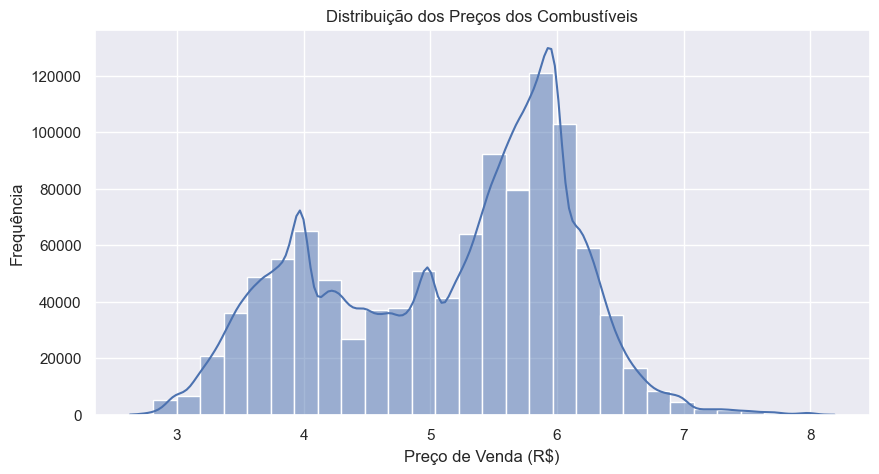

In [20]:
# Criar o gr√°fico de distribui√ß√£o do pre√ßo do combust√≠vel
plt.figure(figsize=(10, 5))  # Ajustar o tamanho da figura
sns.histplot(x=df1_combustiveis['valor_de_venda'], bins=30, kde=True)

# Adicionar t√≠tulo e labels
plt.title('Distribui√ß√£o dos Pre√ßos dos Combust√≠veis')
plt.xlabel('Pre√ßo de Venda (R$)')
plt.ylabel('Frequ√™ncia')

# Mostrar o gr√°fico
plt.show()

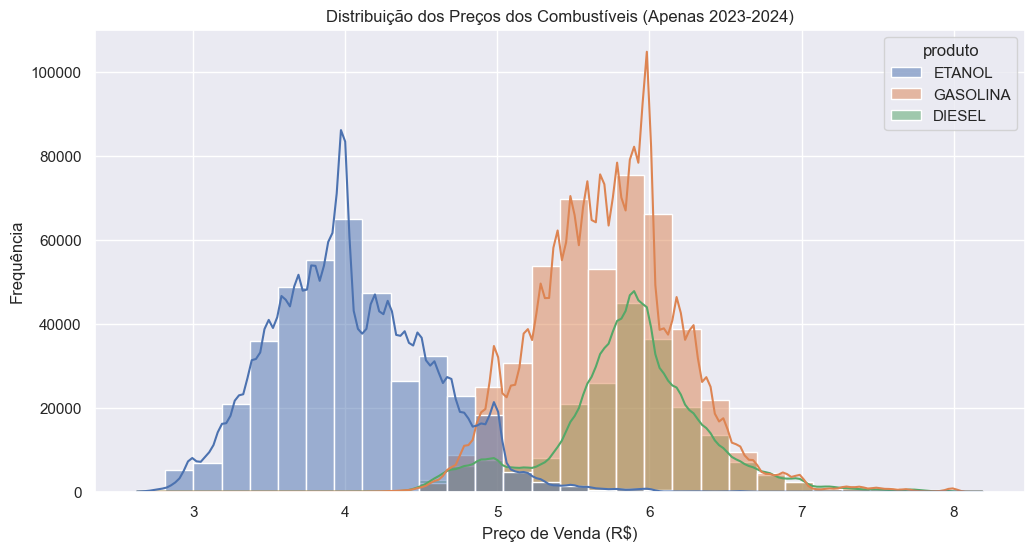

In [21]:
# Criar um gr√°fico de distribui√ß√£o para cada tipo de combust√≠vel
plt.figure(figsize=(12, 6))
sns.histplot(data=df1_combustiveis, x='valor_de_venda', hue='produto', bins=30, kde=True)

# Adicionar t√≠tulo e labels
plt.title('Distribui√ß√£o dos Pre√ßos dos Combust√≠veis (Apenas 2023-2024)')
plt.xlabel('Pre√ßo de Venda (R$)')
plt.ylabel('Frequ√™ncia')

# Mostrar o gr√°fico
plt.show()

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

regiao_sigla             5
estado_sigla            27
municipio              460
revenda              11041
cnpj_da_revenda      12440
nome_da_rua           7833
bairro                5292
cep                   9326
produto                  3
unidade_de_medida        1
bandeira                54
dtype: int64

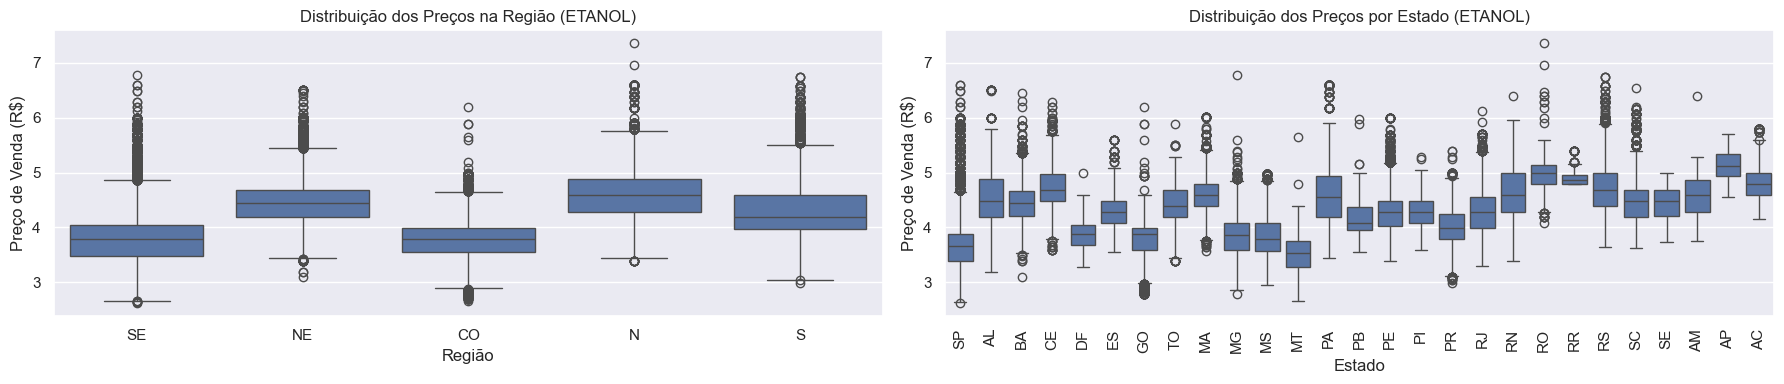

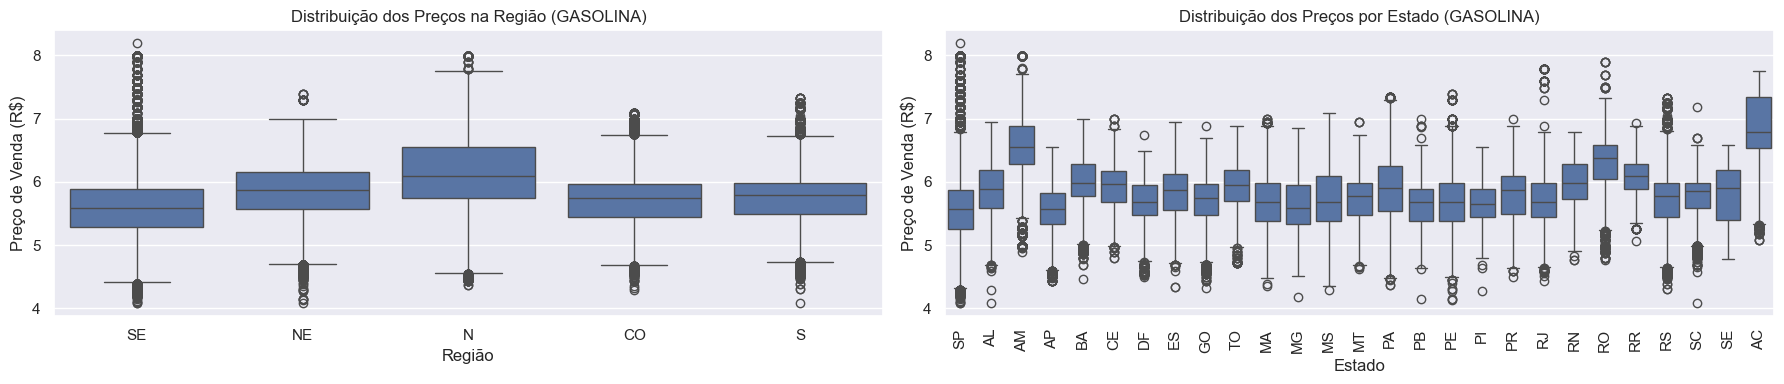

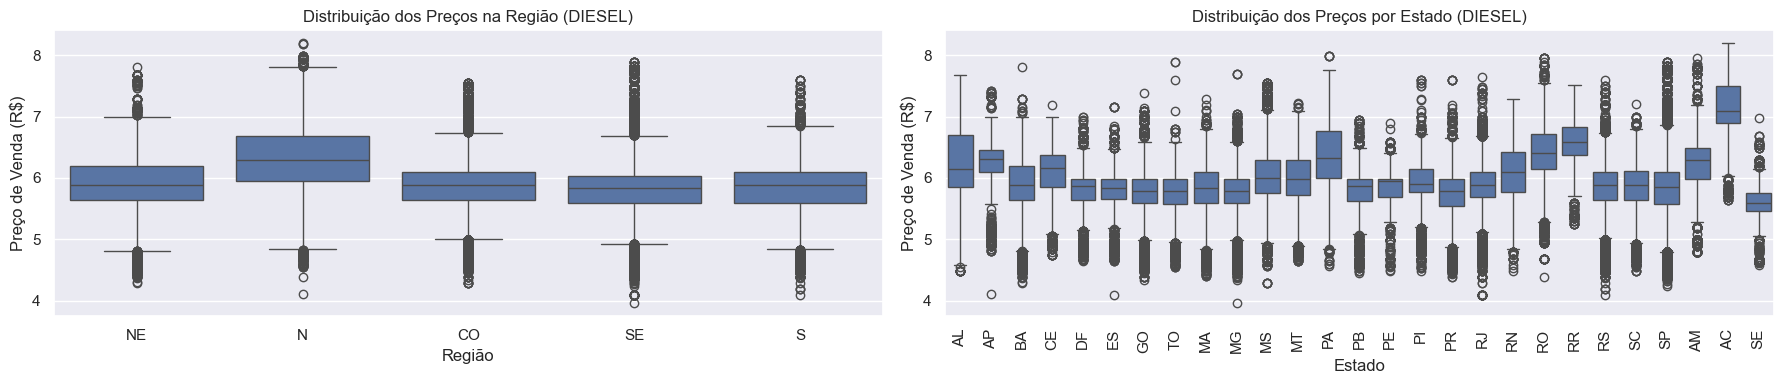

In [23]:
produtos_unicos = df1_combustiveis['produto'].unique()

for produto in produtos_unicos:
    plt.figure(figsize=(18, 4))

    df_filtrado = df1_combustiveis[df1_combustiveis['produto'] == produto]

    # Boxplot por regi√£o
    plt.subplot(1, 2, 1)
    sns.boxplot(x='regiao_sigla', y='valor_de_venda', data=df_filtrado)
    plt.title(f'Distribui√ß√£o dos Pre√ßos na Regi√£o ({produto})')
    plt.xlabel('Regi√£o')
    plt.ylabel('Pre√ßo de Venda (R$)')

    # Boxplot por estado
    plt.subplot(1, 2, 2)
    sns.boxplot(x='estado_sigla', y='valor_de_venda', data=df_filtrado)
    plt.xticks(rotation=90)
    plt.title(f'Distribui√ß√£o dos Pre√ßos por Estado ({produto})')
    plt.xlabel('Estado')
    plt.ylabel('Pre√ßo de Venda (R$)')

    plt.tight_layout()
    plt.show()


### 1.7.3 An√°lise Estat√≠stica dos Pre√ßos dos Combust√≠veis

In [24]:
# Criar tabelas de resumo
tabela_por_regiao = resumo_boxplot(df1_combustiveis, 'regiao_sigla')
tabela_por_estado = resumo_boxplot(df1_combustiveis, 'estado_sigla')
tabela_por_produto = resumo_boxplot(df1_combustiveis, 'produto')

#### **An√°lise por Regi√£o**

In [25]:
display(tabela_por_regiao)

regiao_sigla  Minimo     Q1  Mediana     Q3  Maximo  Media  Desvio_Padrao
0           CO  2.6700 3.9600   5.4400 5.8900  7.5500 5.0236         1.0452
1            N  3.3900 5.1900   5.9800 6.4800  8.1900 5.8398         0.8797
2           NE  3.0900 4.5900   5.4900 5.9800  7.8000 5.3134         0.8031
3            S  2.9900 4.6900   5.5900 5.9700  7.5900 5.3305         0.8157
4           SE  2.6300 3.8900   5.1900 5.7900  8.1900 4.9150         1.0113

**Principais Fatos**
- üî∫ O **Norte** tem a **m√©dia de pre√ßos mais alta (R$ 5.84)** e o **maior valor m√°ximo (R$ 8.19)**.
- üîª O **Sudeste** tem a **m√©dia mais baixa (R$ 4.91)**, indicando menor custo m√©dio de combust√≠veis.
- üìâ O **Centro-Oeste** apresenta a **maior varia√ß√£o de pre√ßos** (Desvio Padr√£o: **1.04**), sugerindo instabilidade nos pre√ßos.

O **Centro-Oeste** apresenta a ***maior varia√ß√£o de pre√ßos*** (Desvio Padr√£o: 1.04), indicando que os pre√ßos na regi√£o flutuam mais do que em outras partes do pa√≠s, o que pode sugerir instabilidade no mercado.


#### **An√°lise por Estado**

In [26]:
display(tabela_por_estado)

estado_sigla  Minimo     Q1  Mediana     Q3  Maximo  Media  Desvio_Padrao
0            AC  4.1500 5.7900   6.7900 7.3000  8.1900 6.4786         1.0374
1            AL  3.1900 4.5900   5.4900 5.9900  7.6700 5.3691         0.8863
2            AM  3.7500 4.8900   6.2700 6.5900  7.9900 5.8505         1.0397
3            AP  4.1200 5.3700   5.6900 6.0500  7.4200 5.7032         0.5391
4            BA  3.0900 4.5800   5.6400 6.0900  7.8000 5.3797         0.8355
5            CE  3.5900 4.7900   5.5500 5.9900  7.1900 5.4090         0.7120
6            DF  3.2800 3.9900   5.4700 5.8700  6.9900 5.0544         0.9442
7            ES  3.5600 4.5400   5.5900 5.9700  7.1500 5.3379         0.8003
8            GO  2.7900 3.9700   5.3900 5.8900  7.3900 4.9947         0.9946
9            MA  3.5800 4.8900   5.5400 5.9200  7.2900 5.4199         0.6593
10           MG  2.7900 3.9800   5.2900 5.7900  7.6900 4.9509         0.9692
11           MS  2.9600 4.0900   5.4900 5.9900  7.5500 5.1817         1.0825
12           MT  2.6700 3.6700   5.4600 5.9500  7.2200 4.9466         1.1842
13           PA  3.4500 5.2500   5.8900 6.3200  7.9900 5.7664         0.8144
14           PB  3.5600 4.2900   5.3900 5.8500  6.9900 5.1136         0.8265
15           PE  3.3900 4.2900   5.0900 5.7400  7.3900 5.0586         0.8163
16           PI  3.5900 4.4900   5.4900 5.8700  7.5900 5.2416         0.7565
17           PR  2.9900 4.1000   5.3900 5.8900  7.5900 5.0678         0.9458
18           RJ  3.3000 4.3900   5.3800 5.8900  7.7900 5.1723         0.8278
19           RN  3.3900 4.8800   5.6800 6.0900  7.2900 5.5047         0.7921
20           RO  4.0900 5.6100   6.2800 6.5900  7.9600 6.1146         0.7107
21           RR  4.7900 5.8900   6.1500 6.5900  7.5200 6.1410         0.5983
22           RS  3.6500 5.1900   5.6900 5.9900  7.5900 5.5647         0.6113
23           SC  3.6200 4.7900   5.6800 5.9700  7.2000 5.4133         0.7160
24           SE  3.7400 4.6900   5.4300 5.9900  6.9800 5.3046         0.7513
25           SP  2.6300 3.7500   5.0900 5.6900  8.1900 4.8038         1.0630
26           TO  3.3900 4.6900   5.6500 5.9900  7.8900 5.3938         0.7845

| **Estado mais caro**  | **Acre (AC) - R$ 6.47** |
|------------------------|----------------------|
| **Estado mais barato** | **S√£o Paulo (SP) - R$ 4.80** |
| **Maior Varia√ß√£o**  | **Mato Grosso (MT) - Desvio Padr√£o: 1.18** |
| **Menor Varia√ß√£o**  | **Amap√° (AP) - Desvio Padr√£o: 0.53** |

**Principais Fatos**
- **Acre (AC) lidera como o estado mais caro**, com m√©dia de **R$ 6.47** e pre√ßos chegando a **R$ 8.19**.
- **S√£o Paulo (SP) tem os pre√ßos mais baixos**, com m√©dia de **R$ 4.80**.
- **Mato Grosso (MT) apresenta a maior instabilidade** nos pre√ßos, variando amplamente (Desvio Padr√£o: 1.18).
- **Amap√° (AP) apresenta pre√ßos mais est√°veis**, com pouca varia√ß√£o.  (Desvio Padr√£o: 0.53)

#### **An√°lise por Produto**

In [27]:
display(tabela_por_produto)

produto  Minimo     Q1  Mediana     Q3  Maximo  Media  Desvio_Padrao
0    DIESEL  3.9700 5.6200   5.8900 6.1400  8.1900 5.8632         0.5053
1    ETANOL  2.6300 3.6900   3.9900 4.3900  7.3500 4.0365         0.5175
2  GASOLINA  4.0900 5.3900   5.7400 5.9900  8.1900 5.7305         0.4727

**Principais Fatos**
- **Diesel tem o maior pre√ßo m√©dio** (**R$ 5.86**) e menor varia√ß√£o.
- **Gasolina tem valores est√°veis**, com mediana **R$ 5.74**.
- **Etanol √© o mais barato (R$ 4.03)**, mas tem **alta varia√ß√£o** nos pre√ßos entre estados.


### **Conclus√£o Geral**
‚úÖ **A regi√£o Norte e o estado do Acre (AC) possuem os combust√≠veis mais caros.**  
‚úÖ **S√£o Paulo (SP) tem os pre√ßos m√©dios mais baixos do pa√≠s.**  
‚úÖ **O Diesel √© o combust√≠vel mais caro, seguido da Gasolina e do Etanol.**  
‚úÖ **O Etanol apresenta a maior varia√ß√£o de pre√ßos entre os estados.**  
‚úÖ **Mato Grosso (MT) tem a maior instabilidade nos pre√ßos.**

Com base nessa an√°lise inicial, percebemos que algumas colunas possuem **muitos valores √∫nicos**, o que pode indicar que n√£o s√£o √∫teis para a an√°lise. No entanto, antes de remover qualquer dado, iremos rodar an√°lises estat√≠sticas e gr√°ficas para embasar nossa decis√£o.

Essa an√°lise nos ajudar√° a entender a relev√¢ncia dessas vari√°veis e se elas impactam nossos insights.

## 1.7.3 Variabilidade das Colunas Categ√≥ricas

In [28]:
df2_combustiveis = df1_combustiveis.copy()

In [29]:
# Criar uma tabela com a contagem de valores √∫nicos
colunas_categoricas = ['revenda', 'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'bairro', 'cep', 'bandeira']
variabilidade_categorica = df2_combustiveis[colunas_categoricas].nunique().reset_index()
variabilidade_categorica.columns = ['Coluna', 'Valores √önicos']

# Exibir a tabela
variabilidade_categorica.sort_values('Valores √önicos', ascending=False)

Coluna  Valores √önicos
1  cnpj_da_revenda           12440
0          revenda           11041
5              cep            9326
2      nome_da_rua            7833
4           bairro            5292
3       numero_rua            3698
6         bandeira              54

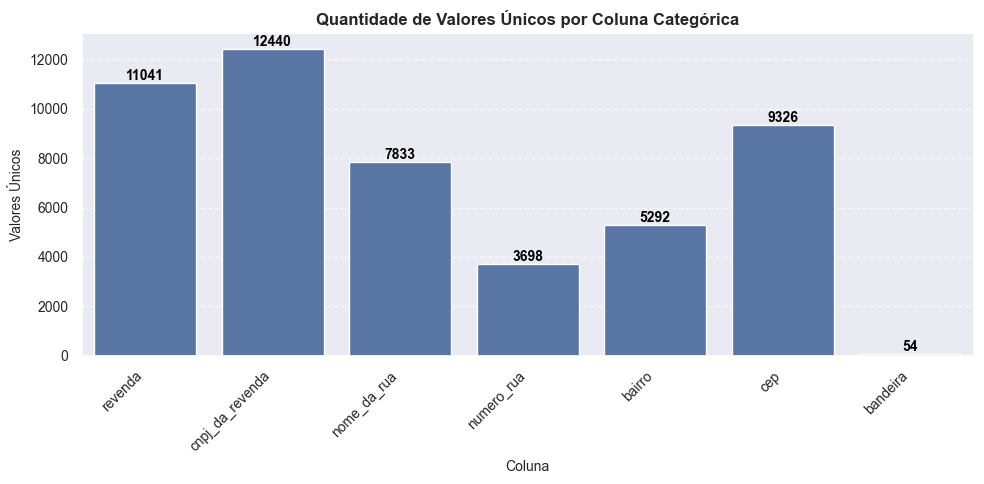

In [30]:
# Criar figura e eixo
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=variabilidade_categorica["Coluna"], y=variabilidade_categorica["Valores √önicos"])

# Adicionar r√≥tulos acima das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Ajustar r√≥tulos e layout
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Quantidade de Valores √önicos por Coluna Categ√≥rica", fontsize=12, fontweight='bold')
plt.ylabel("Valores √önicos", fontsize=10)
plt.xlabel("Coluna", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Exibir gr√°fico
plt.show()

### 1.7.3.1 Teste Estat√≠stico ANOVA: Influ√™ncia das Categorias no Pre√ßo

Para entender se algumas colunas influenciam os pre√ßos dos combust√≠veis, utilizamos o **Teste ANOVA**, que avalia se h√° **diferen√ßa estatisticamente significativa** entre grupos. 

Se o **p-valor for menor que 0.05**, significa que a categoria tem um impacto significativo nos pre√ßos.

In [31]:
# Fun√ß√£o para calcular ANOVA
def calcular_anova(df, coluna):
    grupos = [grupo["valor_de_venda"].dropna().values for _, grupo in df.groupby(coluna)]
    if len(grupos) > 1:
        stat, p_value = stats.f_oneway(*grupos)
        return p_value
    else:
        return None  # Apenas um grupo, sem ANOVA

# Aplicando o teste ANOVA
anova_results = {col: calcular_anova(df2_combustiveis, col) for col in ['bandeira', 'bairro', 'revenda']}

# Criando um DataFrame com os resultados
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['p-valor']).reset_index()
anova_df.rename(columns={'index': 'Coluna'}, inplace=True)

# Exibir tabela de ANOVA
anova_df

Coluna  p-valor
0  bandeira   0.0000
1    bairro   0.0000
2   revenda   0.0000

### 1.7.3.2 Analisando a Varia√ß√£o de Pre√ßo por CEP e CNPJ

In [32]:
# Estat√≠sticas de pre√ßos por CEP e CNPJ
estatisticas_cep = df2_combustiveis.groupby('cep')['valor_de_venda'].agg(['mean', 'std']).reset_index()
estatisticas_cnpj = df2_combustiveis.groupby('cnpj_da_revenda')['valor_de_venda'].agg(['mean', 'std']).reset_index()

# Exibir tabelas
display(estatisticas_cep.head(15))
display(estatisticas_cnpj.head(15))

cep   mean    std
0   00000-000 5.4625 0.6047
1   01102-000 4.0100 0.7420
2   01105-000 5.2400 1.0648
3   01107-000 4.6836 0.8670
4   01124-040 4.1600 0.8634
5   01139-003 4.6498 0.9326
6   01139-040 6.2796 0.9021
7   01141-030 5.0876 0.9965
8   01142-200 4.6380 0.9744
9   01155-000 4.6481 0.9432
10  01216-001 5.0686 1.1012
11  01221-001 6.2400 1.2024
12  01242-000 4.9775 1.0049
13  01270-001 4.5846 0.9554
14  01303-050 6.2313 1.1834

cnpj_da_revenda   mean    std
0    00.001.974/0001-90 5.0139 0.9749
1    00.002.953/0001-99 5.0517 1.0486
2    00.002.953/0002-70 4.9171 1.0230
3    00.003.188/0001-21 4.1075 0.8748
4    00.003.188/0004-74 4.1180 0.8705
5    00.003.188/0005-55 4.2756 0.9095
6    00.003.188/0016-08 4.2638 0.8636
7    00.005.087/0001-90 5.4326 0.5563
8    00.005.892/0001-13 5.2612 0.7535
9    00.007.663/0001-38 4.9878 1.0267
10   00.008.226/0001-39 5.3805 0.3748
11   00.012.211/0002-25 5.0802 0.9948
12   00.012.211/0003-06 4.9819 0.9802
13   00.016.969/0001-50 4.6836 0.8670
14   00.017.512/0001-60 4.3186 1.0414

### Decis√£o Final Sobre as Colunas

Com base nos resultados das an√°lises:

‚úÖ **`Bandeira` deve ser mantida**, pois a ANOVA mostrou que tem um impacto significativo nos pre√ßos.  
‚úÖ **`Bairro` e `Revenda` apresentaram p-valor baixo na ANOVA, indicando que podem influenciar os pre√ßos.** Podemos reavaliar no futuro.  
‚ùå **`CNPJ da Revenda` e `CEP` ser√£o removidos**, pois os pre√ßos dentro desses grupos variam pouco.  
‚ùå **`Nome da Rua` e `N√∫mero Rua` ser√£o removidos**, pois t√™m muitos valores √∫nicos e n√£o agregam valor na previs√£o de pre√ßos.  

Agora que tomamos essas decis√µes, podemos seguir para a an√°lise explorat√≥ria e futura modelagem!

In [33]:
# Agrupando os dados e calculando a m√©dia do pre√ßo para cada combina√ß√£o de Estado, Munic√≠pio, Produto e Data
df3_combustiveis = df2_combustiveis.groupby(['data_da_coleta','regiao_sigla', 'estado_sigla', 'municipio', 'produto', 'bandeira'], as_index=False)['valor_de_venda'].mean()

Para reduzir a volatilidade dos pre√ßos entre diferentes postos, **agregamos os dados** calculando a **m√©dia dos pre√ßos** para cada combina√ß√£o de:

- Regi√£o  
- Estado  
- Munic√≠pio  
- Produto  
- Data  

In [34]:
# Exibir as primeiras linhas dos dados agregados
df3_combustiveis.head()

data_da_coleta regiao_sigla estado_sigla              municipio produto  \
0     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
1     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
2     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
3     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   
4     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   

        bandeira  valor_de_venda  
0         BRANCA          6.5900  
1         RAIZEN          6.5900  
2  VIBRA ENERGIA          6.6900  
3         BRANCA          4.6150  
4       IPIRANGA          4.4900

---

### Justificativa:

- Nosso objetivo √© prever **tend√™ncias regionais dos pre√ßos dos combust√≠veis**, e n√£o o pre√ßo exato de cada posto individualmente. Para isso, realizamos um **processo de agrega√ß√£o dos dados**, reduzindo a granularidade para uma an√°lise mais est√°vel e representativa.
- Os pre√ßos podem **variar entre postos** da mesma cidade, devido √† concorr√™ncia e localiza√ß√£o.  
- A m√©dia reduz **ru√≠do e outliers**, tornando o modelo mais est√°vel.  
- Nosso objetivo n√£o √© prever o pre√ßo exato de um posto, mas **identificar tend√™ncias de pre√ßos em cada regi√£o**.  

### **Transforma√ß√£o dos Dados**
Para minimizar ru√≠dos e varia√ß√µes extremas entre diferentes postos, os dados foram agrupados por:

- ‚úÖ **Data da Coleta** (`data_da_coleta`) ‚Üí Para capturar a varia√ß√£o temporal dos pre√ßos.
- ‚úÖ **Regi√£o** (`regiao_sigla`) ‚Üí Para considerar diferen√ßas macroecon√¥micas regionais.
- ‚úÖ **Estado** (`estado_sigla`) ‚Üí Para captar impactos de pol√≠ticas estaduais e impostos.
- ‚úÖ **Munic√≠pio** (`municipio`) ‚Üí Para capturar tend√™ncias locais nos pre√ßos.
- ‚úÖ **Produto** (`produto`) ‚Üí Diferenciar combust√≠veis como Gasolina, Etanol e Diesel.
- ‚úÖ **Bandeira** (`bandeira`) ‚Üí Algumas marcas possuem pol√≠ticas de pre√ßos distintas.

Para cada combina√ß√£o dessas vari√°veis, calculamos a **m√©dia do pre√ßo de venda (`valor_de_venda`)**.

### **Justificativa da Agrega√ß√£o**
1. **Redu√ß√£o da Variabilidade**  
   - Os pre√ßos entre postos variam devido √† concorr√™ncia e localiza√ß√£o espec√≠fica.
   - A agrega√ß√£o suaviza essas diferen√ßas, **reduzindo ru√≠dos e outliers**.
   
2. **Foco em Tend√™ncias Regionais**   
   - Ao inv√©s de prever o pre√ßo exato de um posto espec√≠fico, queremos **modelar padr√µes de pre√ßos por regi√£o e per√≠odo**.

3. **Melhora na Estabilidade do Modelo**  
   - Reduzimos o impacto de **postos individuais** que podem ter pr√°ticas de precifica√ß√£o at√≠picas.
   
4. **Ajuste para Modelos de Regress√£o**  
   - Agregar os dados garante que o modelo capture padr√µes **macroecon√¥micos e estruturais** em vez de varia√ß√µes muito espec√≠ficas.

### **Resumo Final**
- O dataset final representa a **m√©dia dos pre√ßos por Estado, Munic√≠pio, Produto, Data e Bandeira**.
- Essa abordagem garante um modelo **mais robusto e interpret√°vel**, evitando varia√ß√µes individuais de postos.
- O modelo poder√° **prever tend√™ncias de pre√ßos regionais** com maior confiabilidade.

---
# 2.0. EDA - An√°lise Temporal - Tend√™ncia de Pre√ßos dos Combust√≠veis

Esta se√ß√£o analisa a **varia√ß√£o dos pre√ßos dos combust√≠veis ao longo do tempo**, identificando padr√µes sazonais e tend√™ncias de aumento e redu√ß√£o.

In [35]:
df4_eda_combustiveis = df3_combustiveis.copy()
df4_eda_combustiveis.head()

data_da_coleta regiao_sigla estado_sigla              municipio produto  \
0     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
1     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
2     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
3     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   
4     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   

        bandeira  valor_de_venda  
0         BRANCA          6.5900  
1         RAIZEN          6.5900  
2  VIBRA ENERGIA          6.6900  
3         BRANCA          4.6150  
4       IPIRANGA          4.4900

## 2.1.0 Distribui√ß√£o dos Pre√ßos dos Combust√≠veis

### **Objetivo:**  
Entender como os pre√ßos dos combust√≠veis (Gasolina, Diesel e Etanol) est√£o distribu√≠dos no per√≠odo analisado e identificar padr√µes de precifica√ß√£o.


### **O que analisamos:**
- Criamos um **gr√°fico de distribui√ß√£o (histograma + KDE)** para visualizar a dispers√£o dos pre√ßos.
- Geramos uma **tabela de frequ√™ncia** para entender quantos registros est√£o dentro de cada faixa de pre√ßos.
- A an√°lise foi segmentada por **tipo de combust√≠vel** para facilitar a compara√ß√£o.

In [36]:
df4_eda_combustiveis.describe(exclude=['datetime64[ns]', 'object'])

valor_de_venda
count     491637.0000
mean           5.2088
std            0.9445
min            2.6400
25%            4.3900
50%            5.4900
75%            5.9400
max            8.1900

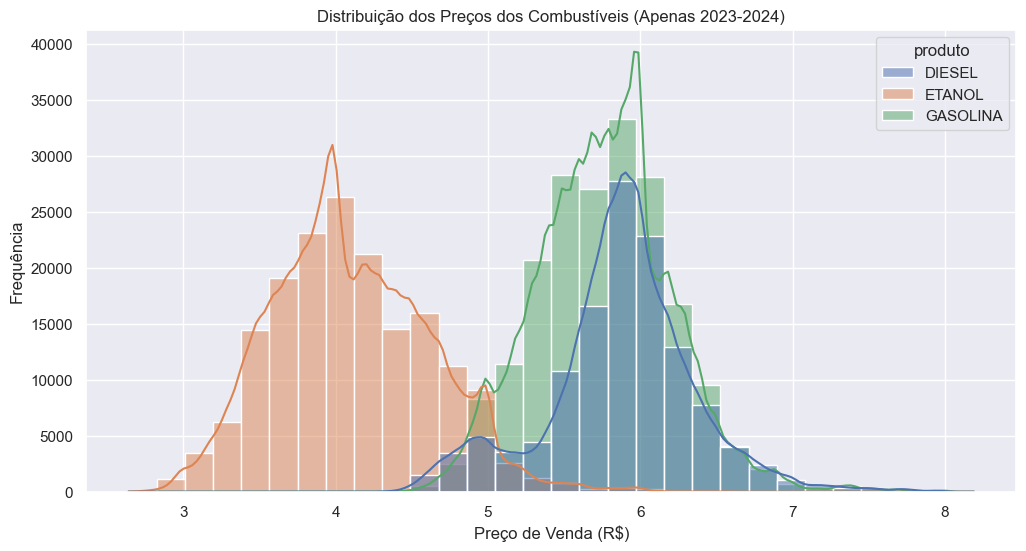

Faixa de Pre√ßo (R$)  Frequ√™ncia (DIESEL)  Frequ√™ncia (ETANOL)  \
0          2.64 - 3.14                    0                 2951   
1          3.14 - 3.64                    0                30752   
2          3.64 - 4.14                    1                62358   
3          4.14 - 4.64                 1231                48051   
4          4.64 - 5.14                10672                23295   
5          5.14 - 5.64                19334                 3301   
6          5.64 - 6.14                63884                  724   
7          6.14 - 6.64                24032                   55   
8          6.64 - 7.14                 5128                    0   
9          7.14 - 7.64                 1033                    1   
10         7.64 - 8.14                  279                    0   
11         8.14 - 8.64                    2                    0   

    Frequ√™ncia (GASOLINA)  
0                       0  
1                       0  
2                       1  
3                     368  
4                   15968  
5                   60112  
6                   82608  
7                   30046  
8                    4356  
9                     921  
10                    173  
11                      0

In [37]:
analisar_distribuicao_precos_por_produto(df4_eda_combustiveis)

### **Interpreta√ß√£o dos Resultados**
- **O Etanol apresenta pre√ßos significativamente mais baixos**, com concentra√ß√£o abaixo de **R$ 4,50**.
- **A Gasolina tem uma distribui√ß√£o centrada entre R$ 5,14 e R$ 6,14**, sendo a faixa mais comum.
- **O Diesel exibe pre√ßos mais altos e maior dispers√£o**, sendo encontrado frequentemente acima de **R$ 6,00**.
- **Poucos registros acima de R$ 7,14** indicam que pre√ßos extremos s√£o raros, podendo estar ligados a fatores log√≠sticos ou regi√µes isoladas.

### **Conclus√£o:**  
- A an√°lise confirma que **cada tipo de combust√≠vel possui um padr√£o distinto de precifica√ß√£o**, influenciado por fatores como **tributa√ß√£o, custo log√≠stico e sazonalidade**.
- A maioria dos pre√ßos est√° dentro de uma faixa bem definida, mas existem varia√ß√µes que podem ser exploradas em an√°lises futuras. 

## 2.2.0  - Tend√™ncia e Sazonalidade dos Pre√ßos dos Combust√≠veis (2023-2024)

### **Objetivo:**  
Analisar a evolu√ß√£o dos pre√ßos dos combust√≠veis (**Gasolina, Diesel e Etanol**) nos anos de **2023 e 2024**, identificando padr√µes de alta, queda e estabilidade, al√©m de poss√≠veis efeitos sazonais.


### **O que analisamos:**
- Calculamos a **m√©dia mensal** dos pre√ßos para cada tipo de combust√≠vel.
- Criamos um **gr√°fico de linha** para visualizar a evolu√ß√£o dos pre√ßos ao longo dos meses.
- Identificamos per√≠odos de **queda, alta e estabilidade** e analisamos **padr√µes sazonais** dentro do ano.


In [38]:
# Garantir que a data esteja no formato correto
df4_eda_combustiveis['data_da_coleta'] = pd.to_datetime(df4_eda_combustiveis['data_da_coleta'])

# Calcular a m√©dia mensal dos pre√ßos para cada produto
df_tendencia = df4_eda_combustiveis.groupby(
    [df4_eda_combustiveis['data_da_coleta'].dt.to_period('M'), 'produto']
)['valor_de_venda'].mean().reset_index()

# Converter para datetime para gr√°fico
df_tendencia['data_da_coleta'] = df_tendencia['data_da_coleta'].astype(str) + '-01'
df_tendencia['data_da_coleta'] = pd.to_datetime(df_tendencia['data_da_coleta'])

# Visualizar os primeiros registros
df_tendencia.head(10)

data_da_coleta   produto  valor_de_venda
0     2023-01-01    DIESEL          6.3528
1     2023-01-01    ETANOL          4.1305
2     2023-01-01  GASOLINA          5.0699
3     2023-02-01    DIESEL          6.0917
4     2023-02-01    ETANOL          4.0846
5     2023-02-01  GASOLINA          5.1335
6     2023-03-01    DIESEL          5.8889
7     2023-03-01    ETANOL          4.1882
8     2023-03-01  GASOLINA          5.5390
9     2023-04-01    DIESEL          5.7614

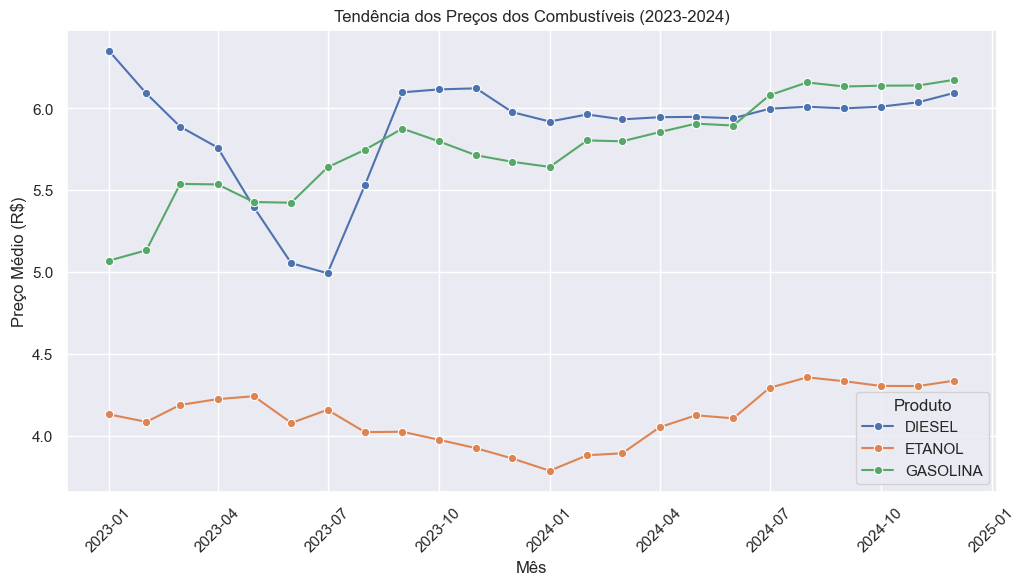

In [39]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_tendencia, x='data_da_coleta', y='valor_de_venda', hue='produto', marker="o")

plt.title("Tend√™ncia dos Pre√ßos dos Combust√≠veis (2023-2024)")
plt.xlabel("M√™s")
plt.ylabel("Pre√ßo M√©dio (R$)")
plt.xticks(rotation=45)
plt.legend(title="Produto")
plt.show()


### **Interpreta√ß√£o dos Resultados**

#### **1Ô∏è. Diesel**
- Forte queda no primeiro semestre de 2023 (R$ 6,35 ‚Üí R$ 4,99 em julho), seguida de uma recupera√ß√£o r√°pida at√© outubro e estabiliza√ß√£o entre R$ 5,90 e R$ 6,10 em 2024. Exibe um padr√£o sazonal claro, com quedas no primeiro semestre e altas no segundo.

#### **2Ô∏è. Gasolina**
- Tend√™ncia de alta moderada ao longo do tempo, com acelera√ß√£o a partir de julho de 2023 e estabiliza√ß√£o acima de R$ 5,50. Apresenta menor volatilidade e oscila√ß√µes suaves sem um ciclo sazonal bem definido.

#### **3Ô∏è. Etanol**
- Pre√ßo mais baixo e oscila√ß√µes bruscas, impactadas pela safra e entressafra da cana-de-a√ß√∫car. Caiu para R$ 3,78 no in√≠cio de 2024, mas recuperou-se gradualmente ao longo do ano, atingindo R$ 4,33 em dezembro. Exibe um padr√£o sazonal c√≠clico, com queda no meio do ano e recupera√ß√£o no final.

### **Conclus√£o:** ***Os pre√ßos dos combust√≠veis seguem padr√µes distintos*** 
- Diesel tem forte sazonalidade.  
- Gasolina mant√©m uma tend√™ncia de alta est√°vel. 
- Etanol oscila com a produ√ß√£o agr√≠cola. 
- A recupera√ß√£o dos pre√ßos em 2024 sugere um mercado mais previs√≠vel, mas sujeito a fatores externos como c√¢mbio e custo do petr√≥leo.


## 2.3.0 - Compara√ß√£o de Tend√™ncia por Ano (2023 vs. 2024)

### **Objetivo:**  
Comparar a evolu√ß√£o dos pre√ßos dos combust√≠veis (**Gasolina, Diesel e Etanol**) nos anos de **2023 e 2024**, destacando mudan√ßas no comportamento dos pre√ßos m√™s a m√™s.



### **O que analisamos:**
- Criamos gr√°ficos separados para cada combust√≠vel, comparando os anos de **2023 e 2024**.
- Geramos uma **tabela com os valores m√©dios por m√™s** para an√°lise num√©rica detalhada.
- Avaliamos se os pre√ßos **seguiram um padr√£o semelhante ou mudaram de comportamento**.


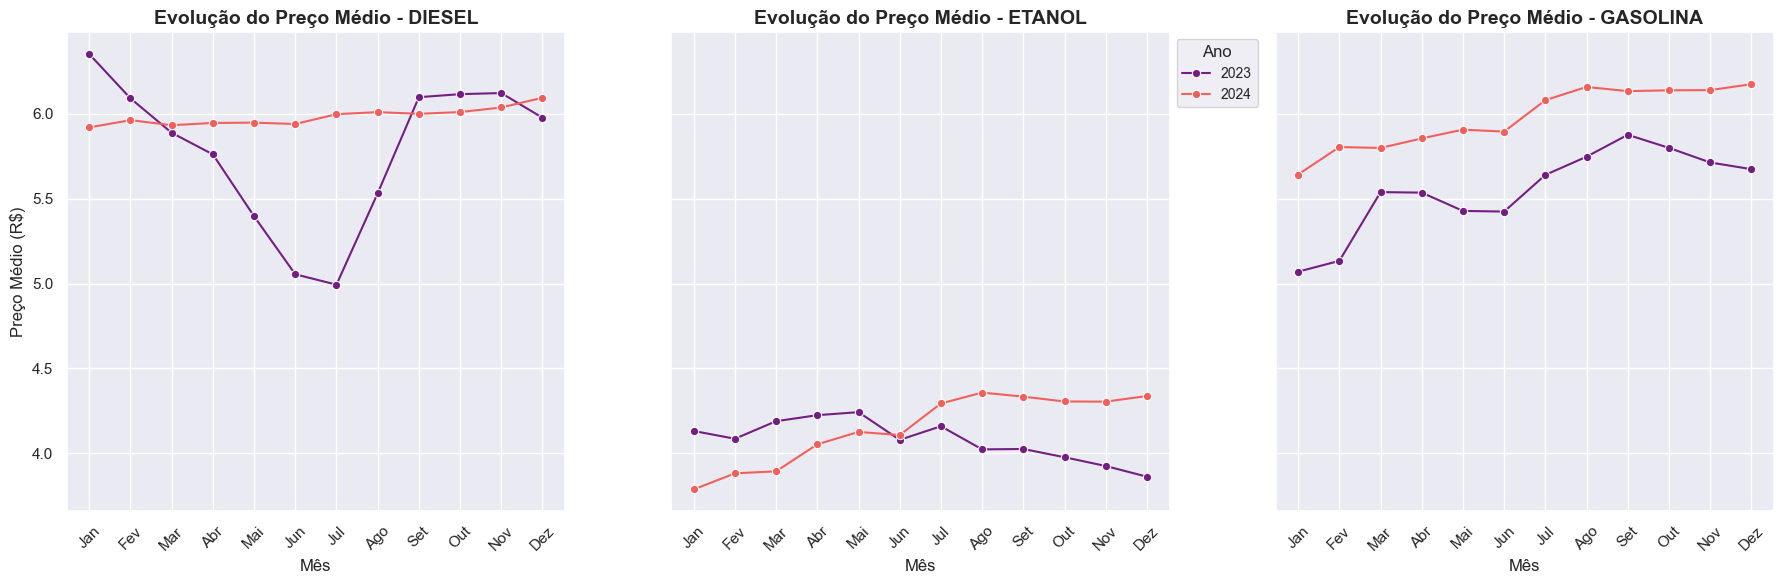

In [40]:
# Criar uma nova coluna com apenas o ano
df4_eda_combustiveis['ano'] = df4_eda_combustiveis['data_da_coleta'].dt.year
df4_eda_combustiveis['mes'] = df4_eda_combustiveis['data_da_coleta'].dt.month

# Calcular a m√©dia de pre√ßos por ano e m√™s para cada combust√≠vel
df_ano_tendencia = df4_eda_combustiveis.groupby(['ano', 'mes', 'produto'])['valor_de_venda'].mean().reset_index()

# Criar figura com subgr√°ficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey=True mant√©m o eixo Y padronizado

# Lista dos combust√≠veis
combustiveis = ["DIESEL", "ETANOL", "GASOLINA"]

# Paleta de cores para diferenciar os anos
cores = sns.color_palette("magma", n_colors=df_ano_tendencia["ano"].nunique())

# Criar um gr√°fico separado para cada combust√≠vel
for i, combustivel in enumerate(combustiveis):
    ax = axes[i]
    
    # Filtrar os dados
    df_filtro = df_ano_tendencia[df_ano_tendencia["produto"] == combustivel]
    
    # Criar o gr√°fico de linhas
    sns.lineplot(
        data=df_filtro,
        x="mes",
        y="valor_de_venda",
        hue="ano",
        marker="o",
        palette=cores,
        ax=ax
    )
    
    # Ajustar os r√≥tulos do eixo X
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)

    # Ajustar t√≠tulo e r√≥tulos
    ax.set_title(f"Evolu√ß√£o do Pre√ßo M√©dio - {combustivel}", fontsize=14, fontweight="bold")
    ax.set_xlabel("M√™s")
    ax.set_ylabel("Pre√ßo M√©dio (R$)")

    # Ajustar a legenda
    if i == 1:  # Somente no gr√°fico do meio
        ax.legend(title="Ano", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()  # Remover a legenda dos outros gr√°ficos para n√£o repetir

# Ajustar espa√ßamento e exibir
plt.tight_layout()
plt.show()

In [41]:
# Calcular a m√©dia dos pre√ßos por m√™s e ano
df_comparacao = df4_eda_combustiveis.groupby(['mes', 'ano', 'produto'])['valor_de_venda'].mean().reset_index()

# Pivotar a tabela para ter colunas separadas por ano
df_comparacao_pivot = df_comparacao.pivot_table(index=['mes', 'produto'], columns='ano', values='valor_de_venda').reset_index()

# Renomear colunas para melhor visualiza√ß√£o
df_comparacao_pivot.columns = ['M√™s', 'Produto', 'Pre√ßo M√©dio 2023', 'Pre√ßo M√©dio 2024']

df_comparacao_pivot

M√™s   Produto  Pre√ßo M√©dio 2023  Pre√ßo M√©dio 2024
0     1    DIESEL            6.3528            5.9202
1     1    ETANOL            4.1305            3.7859
2     1  GASOLINA            5.0699            5.6428
3     2    DIESEL            6.0917            5.9634
4     2    ETANOL            4.0846            3.8806
5     2  GASOLINA            5.1335            5.8048
6     3    DIESEL            5.8889            5.9334
7     3    ETANOL            4.1882            3.8926
8     3  GASOLINA            5.5390            5.7994
9     4    DIESEL            5.7614            5.9468
10    4    ETANOL            4.2236            4.0516
11    4  GASOLINA            5.5360            5.8556
12    5    DIESEL            5.3966            5.9487
13    5    ETANOL            4.2414            4.1249
14    5  GASOLINA            5.4281            5.9073
15    6    DIESEL            5.0543            5.9405
16    6    ETANOL            4.0781            4.1063
17    6  GASOLINA            5.4242            5.8958
18    7    DIESEL            4.9932            5.9985
19    7    ETANOL            4.1583            4.2926
20    7  GASOLINA            5.6404            6.0810
21    8    DIESEL            5.5322            6.0106
22    8    ETANOL            4.0220            4.3568
23    8  GASOLINA            5.7478            6.1590
24    9    DIESEL            6.0988            6.0006
25    9    ETANOL            4.0243            4.3329
26    9  GASOLINA            5.8770            6.1344
27   10    DIESEL            6.1165            6.0110
28   10    ETANOL            3.9756            4.3043
29   10  GASOLINA            5.7999            6.1393
30   11    DIESEL            6.1232            6.0380
31   11    ETANOL            3.9239            4.3035
32   11  GASOLINA            5.7139            6.1404
33   12    DIESEL            5.9776            6.0954
34   12    ETANOL            3.8609            4.3366
35   12  GASOLINA            5.6742            6.1753

### **Interpreta√ß√£o dos Resultados**
#### **1. Diesel**
- Em 2023, teve queda expressiva at√© julho (~R$ 6,35 ‚Üí R$ 4,99), seguida de recupera√ß√£o. 
- Em 2024, oscilou em torno de R$ 6,00 com menor volatilidade, indicando maior estabilidade no mercado.

#### **2Ô∏è. Etanol**
- Em 2023, caiu ao longo do ano, fechando abaixo de R$ 3,80. 
- Em 2024, come√ßou mais baixo, mas apresentou leve recupera√ß√£o a partir de julho (~R$ 4,35), refletindo a safra da cana, pre√ßos da gasolina e pol√≠ticas tribut√°rias.

#### **3Ô∏è. Gasolina**
- Em 2023, subiu gradualmente at√© atingir ~R$ 5,90 - R$ 6,00 em agosto. 
- Em 2024, j√° iniciou mais cara (~R$ 5,90) e seguiu um padr√£o de alta moderada, chegando a ~R$ 6,20 no final do ano, sugerindo influ√™ncia de reajustes da Petrobras e tributos.


### **Conclus√£o Geral**
- Diesel ficou mais est√°vel em 2024, reduzindo volatilidade.
- Etanol teve um comportamento inverso entre os anos, caindo em 2023 e subindo em 2024.
- Gasolina iniciou 2024 em um patamar mais alto, mantendo tend√™ncia de alta.
- A an√°lise mensal refor√ßa o impacto de fatores como safra, tributos e reajustes no mercado.

## 2.4.0 - Compara√ß√£o Regional dos Pre√ßos

### **Objetivo:**  
Analisar como os pre√ßos m√©dios dos combust√≠veis **variam entre diferentes regi√µes e estados**, destacando padr√µes e discrep√¢ncias.  

### **O que analisamos:**  
- Criamos **boxplots separados por tipo de combust√≠vel** para visualizar a dispers√£o dos pre√ßos por **regi√£o**.  
- Geramos uma **tabela comparativa**, onde podemos observar os pre√ßos m√©dios e a varia√ß√£o (**desvio padr√£o**) por **regi√£o e estado**.  


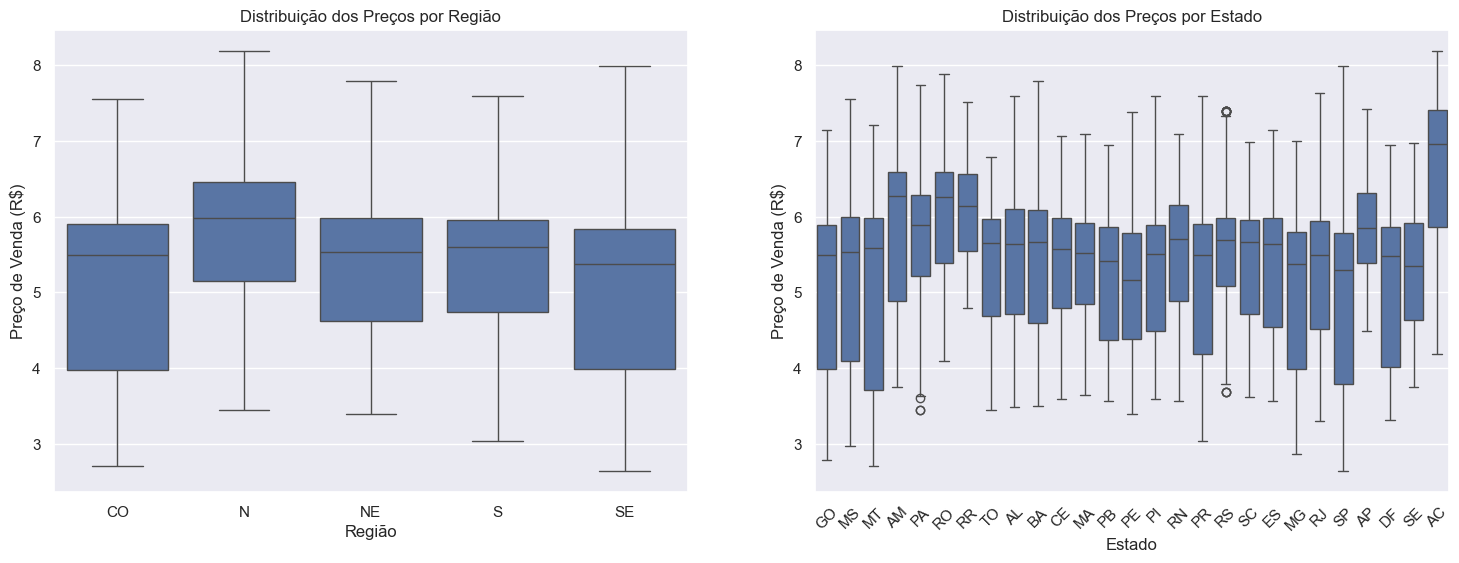

In [42]:
# Criando boxplots para visualizar distribui√ß√£o dos pre√ßos por regi√£o e estado
plt.figure(figsize=(18, 6))

# Boxplot por regi√£o
plt.subplot(1, 2, 1)
sns.boxplot(data=df4_eda_combustiveis, x='regiao_sigla', y='valor_de_venda')
plt.title("Distribui√ß√£o dos Pre√ßos por Regi√£o")
plt.xlabel("Regi√£o")
plt.ylabel("Pre√ßo de Venda (R$)")

# Boxplot por estado
plt.subplot(1, 2, 2)
sns.boxplot(data=df4_eda_combustiveis, x='estado_sigla', y='valor_de_venda')
plt.xticks(rotation=45)
plt.title("Distribui√ß√£o dos Pre√ßos por Estado")
plt.xlabel("Estado")
plt.ylabel("Pre√ßo de Venda (R$)")

plt.show()

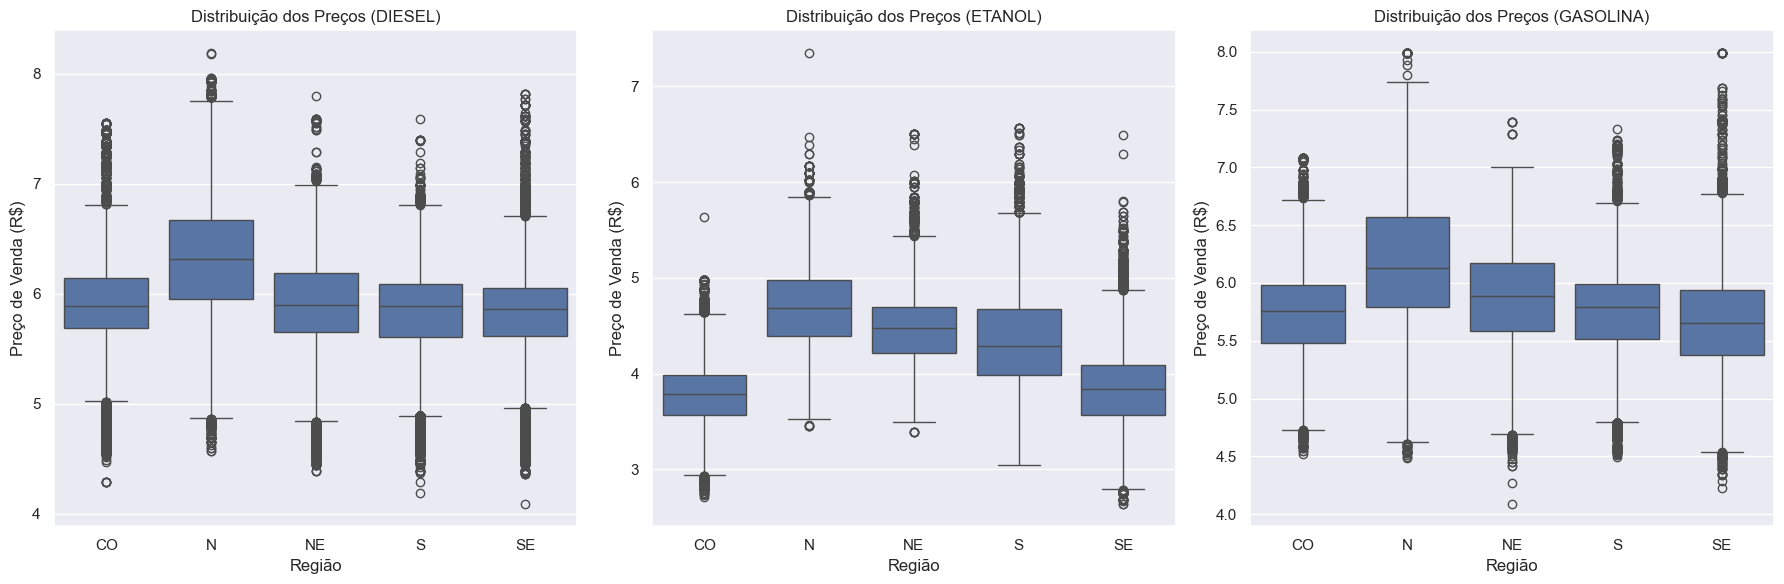

In [43]:
# Criar gr√°ficos de boxplot para cada tipo de combust√≠vel
plt.figure(figsize=(18, 6))

combustiveis = df4_eda_combustiveis['produto'].unique()

for i, combustivel in enumerate(combustiveis):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df4_eda_combustiveis[df4_eda_combustiveis['produto'] == combustivel], 
                x='regiao_sigla', y='valor_de_venda')
    plt.title(f"Distribui√ß√£o dos Pre√ßos ({combustivel})")
    plt.xlabel("Regi√£o")
    plt.ylabel("Pre√ßo de Venda (R$)")

plt.tight_layout()
plt.show()


In [44]:
# Criar tabela de m√©dia e desvio por regi√£o
tabela_regiao = df4_eda_combustiveis.groupby(['regiao_sigla', 'produto'])['valor_de_venda'].agg(['mean', 'std']).reset_index()

# Pivotar para ter combust√≠veis como colunas (m√©dia e desvio padr√£o juntos)
tabela_regiao_pivot = tabela_regiao.pivot(index='regiao_sigla', columns='produto', values=['mean', 'std'])

# Renomear colunas
tabela_regiao_pivot.columns = [f'{combustivel} M√©dia (R$)' if metrica == 'mean' else f'{combustivel} ¬± (R$)' 
                               for metrica, combustivel in tabela_regiao_pivot.columns]
tabela_regiao_pivot.reset_index(inplace=True)

# Criar a mesma estrutura para os estados
tabela_estado = df4_eda_combustiveis.groupby(['estado_sigla', 'produto'])['valor_de_venda'].agg(['mean', 'std']).reset_index()
tabela_estado_pivot = tabela_estado.pivot(index='estado_sigla', columns='produto', values=['mean', 'std'])
tabela_estado_pivot.columns = [f'{combustivel} M√©dia (R$)' if metrica == 'mean' else f'{combustivel} ¬± (R$)' 
                               for metrica, combustivel in tabela_estado_pivot.columns]
tabela_estado_pivot.reset_index(inplace=True)

# Exibir tabelas com m√©dia e desvio juntos
display(tabela_regiao_pivot)
display(tabela_estado_pivot)

regiao_sigla  DIESEL M√©dia (R$)  ETANOL M√©dia (R$)  GASOLINA M√©dia (R$)  \
0           CO             5.8864             3.7967               5.7341   
1            N             6.3068             4.6944               6.1703   
2           NE             5.8785             4.4769               5.8624   
3            S             5.8038             4.3378               5.7670   
4           SE             5.8077             3.8563               5.6459   

   DIESEL ¬± (R$)  ETANOL ¬± (R$)  GASOLINA ¬± (R$)  
0         0.5017         0.3579           0.4133  
1         0.6084         0.4296           0.5976  
2         0.4845         0.3711           0.4348  
3         0.4295         0.4951           0.3781  
4         0.4488         0.4161           0.4047

estado_sigla  DIESEL M√©dia (R$)  ETANOL M√©dia (R$)  GASOLINA M√©dia (R$)  \
0            AC             7.2163             5.0325               6.9572   
1            AL             6.1676             4.5652               5.9897   
2            AM             6.3230             4.5507               6.5436   
3            AP             6.2359             5.1531               5.5978   
4            BA             5.8729             4.4339               6.0169   
5            CE             6.0125             4.7417               5.9639   
6            DF             5.7992             3.8734               5.6480   
7            ES             5.7636             4.3245               5.8757   
8            GO             5.7740             3.8335               5.7031   
9            MA             5.7847             4.6118               5.6933   
10           MG             5.7478             3.8673               5.6487   
11           MS             6.0958             3.9152               5.7799   
12           MT             6.0007             3.5416               5.7978   
13           PA             6.3008             4.6684               5.9279   
14           PB             5.7980             4.1960               5.6438   
15           PE             5.8209             4.3453               5.7412   
16           PI             5.8780             4.3206               5.6443   
17           PR             5.7434             4.0056               5.7934   
18           RJ             5.8868             4.3615               5.8014   
19           RN             6.0500             4.6749               5.9934   
20           RO             6.4143             4.9672               6.3181   
21           RR             6.4985             4.9106               6.1265   
22           RS             5.8314             4.7407               5.7294   
23           SC             5.8506             4.4751               5.7932   
24           SE             5.5867             4.4133               5.8175   
25           SP             5.8243             3.6734               5.5738   
26           TO             5.7303             4.4529               5.9624   

    DIESEL ¬± (R$)  ETANOL ¬± (R$)  GASOLINA ¬± (R$)  
0          0.5045         0.4407           0.5775  
1          0.6049         0.4665           0.4495  
2          0.5654         0.3290           0.6328  
3          0.5134         0.2454           0.3716  
4          0.4805         0.2932           0.3734  
5          0.4651         0.3123           0.3441  
6          0.4091         0.2349           0.3416  
7          0.3954         0.2913           0.4355  
8          0.4301         0.3122           0.3742  
9          0.4329         0.3258           0.4610  
10         0.4154         0.3269           0.3882  
11         0.6255         0.4260           0.5219  
12         0.4655         0.3067           0.3859  
13         0.5353         0.5005           0.4952  
14         0.4236         0.3053           0.3733  
15         0.4272         0.3664           0.4792  
16         0.4352         0.2641           0.3047  
17         0.4218         0.3186           0.3774  
18         0.4473         0.3633           0.3892  
19         0.5198         0.4377           0.3913  
20         0.5283         0.2708           0.4816  
21         0.4338         0.1435           0.3623  
22         0.4392         0.4559           0.4024  
23         0.4053         0.3636           0.3289  
24         0.4278         0.3022           0.4656  
25         0.4676         0.3276           0.3917  
26         0.3906         0.3127           0.3813

**O desvio padr√£o indica o n√≠vel de varia√ß√£o dos pre√ßos dentro de cada regi√£o.** 

### **Interpreta√ß√£o dos Resultados**  

#### **1. Diferen√ßas Regionais**
- Regi√£o Norte tem os pre√ßos m√©dios mais altos para todos os combust√≠veis, com maior varia√ß√£o.
- Centro-Oeste apresenta os menores pre√ßos para o Etanol, enquanto Diesel e Gasolina t√™m maior oscila√ß√£o.
- Sudeste tem pre√ßos mais homog√™neos, especialmente para Diesel e Gasolina.

**Fatores que explicam:**  
- Custos log√≠sticos e distribui√ß√£o impactam diretamente os pre√ßos nas regi√µes.
- Estados produtores de Etanol (SP e GO) possuem pre√ßos menores devido √† maior oferta.
- Pol√≠ticas de ICMS estaduais influenciam o valor final ao consumidor.


#### **2Ô∏è. Diferen√ßas Estaduais**
- Acre, Amazonas e Rond√¥nia possuem os pre√ßos mais altos, refletindo desafios log√≠sticos.
- S√£o Paulo e Goi√°s t√™m os menores pre√ßos para Etanol e Gasolina, impulsionados pela produ√ß√£o local.
- Roraima e Amap√° apresentam baixa varia√ß√£o nos pre√ßos, sugerindo menor concorr√™ncia.

### **Conclus√£o**
- Regi√µes Norte e Nordeste enfrentam pre√ßos mais altos e vol√°teis.
- Centro-Oeste e Sudeste possuem valores mais baixos, especialmente no Etanol.
- Fatores log√≠sticos, produ√ß√£o interna e tributa√ß√£o estadual s√£o determinantes na precifica√ß√£o.

---
# 3.0. An√°lise de Correla√ß√£o com Vari√°veis Macroecon√¥micas

Nesta se√ß√£o, investigamos **como os pre√ßos dos combust√≠veis s√£o influenciados** por fatores macroecon√¥micos, como:
- **Taxa de c√¢mbio (USD/BRL)** ‚Üí Impacto no custo da importa√ß√£o de petr√≥leo e derivados.
- **Infla√ß√£o (IPCA)** ‚Üí Poss√≠vel efeito sobre o custo de vida e consumo.
- **Pre√ßo do petr√≥leo (Brent e WTI)** ‚Üí Base de precifica√ß√£o dos combust√≠veis no mercado internacional.
- **Taxa SELIC** ‚Üí Influ√™ncia indireta nos investimentos e no custo de cr√©dito para o setor.

O objetivo desta an√°lise √©:

‚úÖ **Identificar correla√ß√µes significativas** entre os pre√ßos dos combust√≠veis e vari√°veis macroecon√¥micas.  
‚úÖ **Avaliar a for√ßa e o sentido dessas rela√ß√µes**, ajudando na constru√ß√£o de modelos preditivos.  
‚úÖ **Analisar se o impacto dessas vari√°veis ocorre de forma imediata ou com defasagem temporal.**  
‚úÖ **Quantificar os efeitos dessas vari√°veis no pre√ßo dos combust√≠veis.** 

---

## Tratamento inicial para Dados Macroecon√¥micos `df_macro`

Os dados macroecon√¥micos precisam ser preparados antes do merge com os pre√ßos dos combust√≠veis.  
As seguintes etapas s√£o realizadas:
- **Padroniza√ß√£o dos nomes das colunas** para facilitar a manipula√ß√£o dos dados.
- **Convers√£o da coluna de data** para o formato `datetime`, garantindo compatibilidade na mesclagem.
- **Filtragem para manter apenas os dados a partir de 2023**, pois queremos analisar o impacto recente dessas vari√°veis.
- **An√°lise de colunas vazias e qualidade dos dados** para verificar se h√° problemas estruturais.
- **Verifica√ß√£o e remo√ß√£o de duplicatas**, evitando distor√ß√µes no merge.
- **Consolida√ß√£o dos dados macroecon√¥micos** para garantir **uma √∫nica entrada por dia**, prevenindo duplica√ß√µes indesejadas.

In [45]:
# 1. Renomeando colunas para um formato padronizado
colunas_antigas = df_macro.columns.to_list()
colunas_novas = [renomear_coluna(col) for col in colunas_antigas]
df_macro = df_macro.rename(columns=dict(zip(colunas_antigas, colunas_novas)))

In [46]:
# 2. Convertendo a coluna de data para datetime
df_macro['date'] = pd.to_datetime(df_macro['date'])

In [47]:
# 3. Filtrando os dados macroecon√¥micos a partir de 2023
df_macro = df_macro[df_macro['date'].dt.year >= 2023]

In [48]:
# 4. Analisando colunas vazias e qualidade dos dados antes do merge
display(analisar_colunas_vazias(df_macro))
display(analisar_qualidade_dados(df_macro))

Coluna  Valores Nulos  Porcentagem de Nulos (%)  100% Vazia  \
0         date              0                    0.0000       False   
1     taxa_usd              0                    0.0000       False   
2         ipca              0                    0.0000       False   
3  brent_price              0                    0.0000       False   
4    wti_price              0                    0.0000       False   
5        selic              0                    0.0000       False   

   Possui Nulos  Valor √önico (Poss√≠vel Constante)  
0         False                             False  
1         False                             False  
2         False                             False  
3         False                             False  
4         False                             False  
5         False                             False

Linhas Duplicadas no DataFrame: 17


Coluna  Valores Vazios ("")  Espa√ßos em Branco (" ")  Valores √önicos
0         date                    0                        0             771
1     taxa_usd                    0                        0             632
2         ipca                    0                        0              21
3  brent_price                    0                        0             447
4    wti_price                    0                        0             439
5        selic                    0                        0               8

In [49]:
# 5. Verificando a exist√™ncia de valores duplicados
df_duplicadas = df_macro[df_macro.duplicated(keep=False)]
if not df_duplicadas.empty:
    display(df_duplicadas.shape)  # Mostra quantas duplicatas existem antes da limpeza

(34, 6)

In [50]:
# 6. Removendo duplicatas e consolidando as informa√ß√µes por data
df_macro = df_macro.drop_duplicates()  # Remove entradas id√™nticas
df_macro = df_macro.groupby('date', as_index=False).mean()  # Garante uma √∫nica entrada por dia

In [51]:
# 7. Verificando o resultado final do tratamento
display(df_macro.head())
display(df_macro.dtypes)

date  taxa_usd   ipca  brent_price  wti_price   selic
0 2023-01-01    5.2860 0.5300      85.9100    80.2600 13.7500
1 2023-01-02    5.3633 0.5300      85.9100    80.2600 13.7500
2 2023-01-03    5.4797 0.5300      82.1000    76.9300 13.7500
3 2023-01-04    5.4312 0.5300      77.8400    72.8400 13.7500
4 2023-01-05    5.3509 0.5300      78.6900    73.6700 13.7500

date           datetime64[ns]
taxa_usd              float64
ipca                  float64
brent_price           float64
wti_price             float64
selic                 float64
dtype: object

## Mesclagem dos Dados Macroecon√¥micos com os Dados de Combust√≠veis
Agora, unimos os dados macroecon√¥micos ao conjunto de dados de combust√≠veis, garantindo que cada linha mantenha sua integridade original.


In [52]:
# Realizando o merge
df_final_00 = df4_eda_combustiveis.merge(df_macro, left_on='data_da_coleta', right_on='date', how='left')

# Removendo a coluna redundante 'date'
df_final_00.drop(columns=['date'], inplace=True)

# Visualizando os primeiros registros ap√≥s o merge
display(df_final_00.head())

# Analisando colunas vazias e qualidade dos dados p√≥s-merge
analisar_colunas_vazias(df_final_00)
analisar_qualidade_dados(df_final_00)

# Verificando duplicatas ap√≥s a mesclagem
df_duplicadas = df_final_00[df_final_00.duplicated(keep=False)]
display(df_duplicadas.head())

# Comparando o tamanho dos DataFrames antes e depois do merge
print(f"Tamanho original do df4_eda_combustiveis: {df4_eda_combustiveis.shape}")
print(f"Tamanho ap√≥s o merge: {df_final_00.shape}")

data_da_coleta regiao_sigla estado_sigla              municipio produto  \
0     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
1     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
2     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
3     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   
4     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  ETANOL   

        bandeira  valor_de_venda   ano  mes  taxa_usd   ipca  brent_price  \
0         BRANCA          6.5900  2023    1    5.3633 0.5300      85.9100   
1         RAIZEN          6.5900  2023    1    5.3633 0.5300      85.9100   
2  VIBRA ENERGIA          6.6900  2023    1    5.3633 0.5300      85.9100   
3         BRANCA          4.6150  2023    1    5.3633 0.5300      85.9100   
4       IPIRANGA          4.4900  2023    1    5.3633 0.5300      85.9100   

   wti_price   selic  
0    80.2600 13.7500  
1    80.2600 13.7500  
2    80.2600 13.7500  
3    80.2600 13.7500  
4    80.2600 13.7500

Linhas Duplicadas no DataFrame: 0


Empty DataFrame
Columns: [data_da_coleta, regiao_sigla, estado_sigla, municipio, produto, bandeira, valor_de_venda, ano, mes, taxa_usd, ipca, brent_price, wti_price, selic]
Index: []

Tamanho original do df4_eda_combustiveis: (491637, 9)
Tamanho ap√≥s o merge: (491637, 14)


---
## 3.1 Matriz de Correla√ß√£o e Defasagem (Lag Analysis)

### **3.1.1 Matriz de Correla√ß√£o**

A matriz de correla√ß√£o mede o **grau de associa√ß√£o linear** entre as vari√°veis.  
Os valores variam de **-1 a 1**:
- **1.00** ‚Üí Correla√ß√£o positiva perfeita (as vari√°veis sobem ou descem juntas).
- **0.00** ‚Üí Sem correla√ß√£o (n√£o h√° rela√ß√£o linear entre as vari√°veis).
- **-1.00** ‚Üí Correla√ß√£o negativa perfeita (quando uma vari√°vel sobe, a outra desce).

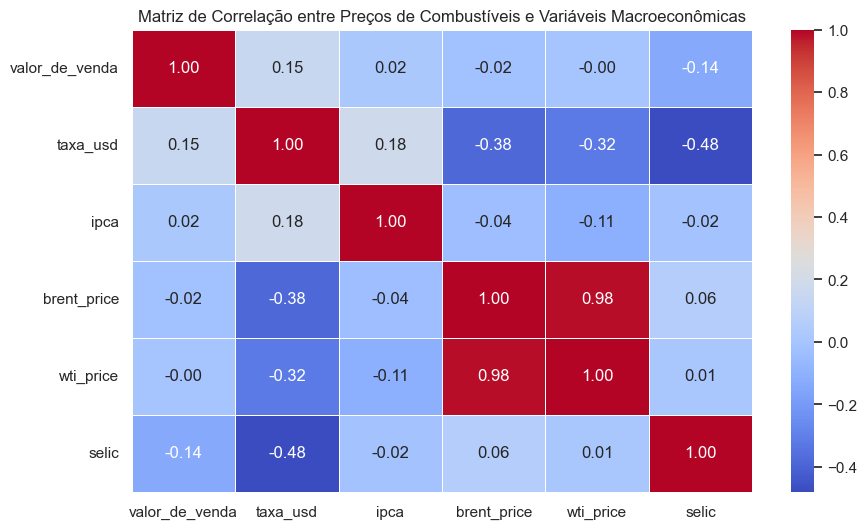

In [53]:
# Selecionando apenas as colunas relevantes para a correla√ß√£o
cols_corr = ['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']

# Calculando a matriz de correla√ß√£o
corr_matrix = df_final_00[cols_corr].corr()

# Criando o heatmap da correla√ß√£o
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correla√ß√£o entre Pre√ßos de Combust√≠veis e Vari√°veis Macroecon√¥micas")
plt.show()

In [54]:
# Criando a matriz de correla√ß√£o em formato de tabela
df_correlation = df_final_00[cols_corr].corr()

# Exibindo a matriz de correla√ß√£o no notebook
display(df_correlation)

valor_de_venda  taxa_usd    ipca  brent_price  wti_price  \
valor_de_venda          1.0000    0.1488  0.0210      -0.0188    -0.0020   
taxa_usd                0.1488    1.0000  0.1847      -0.3843    -0.3209   
ipca                    0.0210    0.1847  1.0000      -0.0352    -0.1095   
brent_price            -0.0188   -0.3843 -0.0352       1.0000     0.9842   
wti_price              -0.0020   -0.3209 -0.1095       0.9842     1.0000   
selic                  -0.1352   -0.4800 -0.0173       0.0589     0.0087   

                 selic  
valor_de_venda -0.1352  
taxa_usd       -0.4800  
ipca           -0.0173  
brent_price     0.0589  
wti_price       0.0087  
selic           1.0000

### **3.1.2 An√°lise de Defasagem (Lag Analysis)**

Os pre√ßos dos combust√≠veis podem **n√£o reagir imediatamente** √†s mudan√ßas macroecon√¥micas.  
Por exemplo, uma alta no **Brent** pode demorar algumas semanas para impactar os pre√ßos nas bombas.  

Isso pode ocorrer por diversos motivos, como:
- **Pol√≠tica de Pre√ßos da Petrobras** ‚Üí Os ajustes nos combust√≠veis n√£o seguem a cota√ß√£o do Brent diariamente.
- **Contratos de Fornecimento** ‚Üí Empresas podem comprar petr√≥leo a pre√ßos fixos por per√≠odos, reduzindo a volatilidade imediata.
- **Estoque de Combust√≠veis** ‚Üí Varia√ß√µes nos pre√ßos do petr√≥leo podem demorar para refletir no pre√ßo final devido ao tempo de refino e distribui√ß√£o.

Para verificar essa rela√ß√£o **ao longo do tempo**, realizamos uma an√°lise de **defasagem temporal (lag analysis)**, deslocando as vari√°veis macroecon√¥micas e observando suas correla√ß√µes com os pre√ßos futuros dos combust√≠veis.


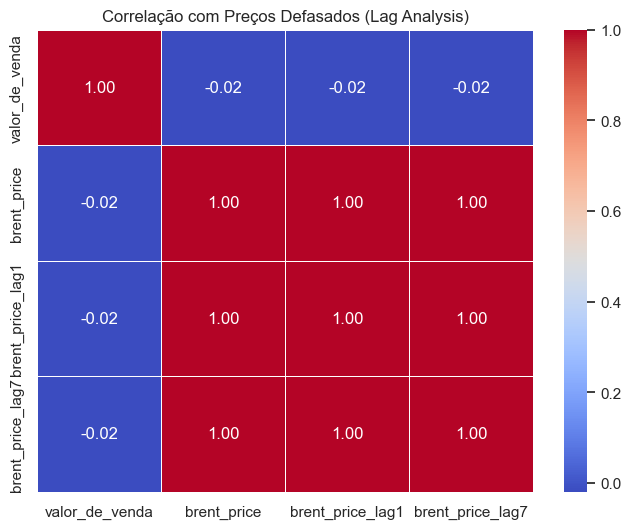

valor_de_venda  brent_price  brent_price_lag1  \
valor_de_venda            1.0000      -0.0188           -0.0188   
brent_price              -0.0188       1.0000            1.0000   
brent_price_lag1         -0.0188       1.0000            1.0000   
brent_price_lag7         -0.0188       0.9997            0.9998   

                  brent_price_lag7  
valor_de_venda             -0.0188  
brent_price                 0.9997  
brent_price_lag1            0.9998  
brent_price_lag7            1.0000

Vari√°vel  Correla√ß√£o com Pre√ßo
0    Brent (Imediato)               -0.0188
1   Brent (Lag 1 dia)               -0.0188
2  Brent (Lag 7 dias)               -0.0188

In [55]:
# Criando vari√°veis defasadas (lags) para an√°lise de impacto retardado
df_final_00['brent_price_lag1'] = df_final_00['brent_price'].shift(1)  # Defasagem de 1 dia
df_final_00['brent_price_lag7'] = df_final_00['brent_price'].shift(7)  # Defasagem de 7 dias

# Matriz de correla√ß√£o com vari√°veis defasadas
cols_corr_lag = ['valor_de_venda', 'brent_price', 'brent_price_lag1', 'brent_price_lag7']
corr_matrix_lag = df_final_00[cols_corr_lag].corr()

# Criando heatmap para correla√ß√µes defasadas
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_lag, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correla√ß√£o com Pre√ßos Defasados (Lag Analysis)")
plt.show()

# Criando a matriz de correla√ß√£o com defasagens
df_correlation_lag = df_final_00[cols_corr_lag].corr()

# Exibindo a matriz de correla√ß√£o defasada no notebook
display(df_correlation_lag)

# Criando um dataframe comparativo
df_lag_comparacao = pd.DataFrame({
    'Vari√°vel': ['Brent (Imediato)', 'Brent (Lag 1 dia)', 'Brent (Lag 7 dias)'],
    'Correla√ß√£o com Pre√ßo': [
        df_correlation.loc['valor_de_venda', 'brent_price'],
        df_correlation_lag.loc['valor_de_venda', 'brent_price_lag1'],
        df_correlation_lag.loc['valor_de_venda', 'brent_price_lag7']
    ]
})

# Exibindo a tabela de compara√ß√£o
display(df_lag_comparacao)

###  Conclus√£o Matriz de Correla√ß√£o e Defasagem (Lag Analysis)

**Correla√ß√£o entre Brent e Pre√ßo dos Combust√≠veis:**
 
- Correla√ß√£o extremamente baixa (-0.0188), tanto imediata quanto defasada (1 e 7 dias).
- Mesmo testando diferentes atrasos, o Brent n√£o afeta diretamente os pre√ßos no curto prazo. 

**Fatores que influenciam mais:**  
- Taxa de c√¢mbio (USD/BRL) tem impacto moderado (~0.15), sugerindo que a varia√ß√£o cambial influencia os pre√ßos.
- IPCA e SELIC t√™m efeito indireto, impactando custos e demanda no longo prazo.  

**Conclus√£o:**
Os pre√ßos dos combust√≠veis n√£o seguem diretamente as oscila√ß√µes do Brent, pois fatores internos predominam:
- Pol√≠tica de pre√ßos da Petrobras, que evita repasses autom√°ticos.
- Tributa√ß√£o e regula√ß√µes, que podem amortecer varia√ß√µes do petr√≥leo.
- Produ√ß√£o nacional de petr√≥leo, reduzindo a depend√™ncia do mercado externo.

## 3.2 Gr√°ficos de Dispers√£o e Quantifica√ß√£o da Rela√ß√£o (Regress√£o Linear)

Nesta se√ß√£o, analisamos visualmente e quantitativamente **como os pre√ßos dos combust√≠veis variam em rela√ß√£o √†s vari√°veis macroecon√¥micas**.

**Objetivos:**
- **Visualizar a rela√ß√£o** entre as vari√°veis usando gr√°ficos de dispers√£o.
- **Identificar tend√™ncias e padr√µes** (exemplo: o pre√ßo do combust√≠vel sobe quando o Brent sobe?).
- **Quantificar a influ√™ncia** de cada vari√°vel sobre o pre√ßo do combust√≠vel atrav√©s da regress√£o linear.


### **3.2.1 Gr√°ficos de Dispers√£o**

Os gr√°ficos de dispers√£o s√£o √∫teis para observar **se h√° uma rela√ß√£o visual clara** entre os pre√ßos dos combust√≠veis e as vari√°veis macroecon√¥micas.

Caso exista uma tend√™ncia nos pontos (exemplo: uma linha ascendente), isso pode indicar **uma correla√ß√£o positiva** entre as vari√°veis.  

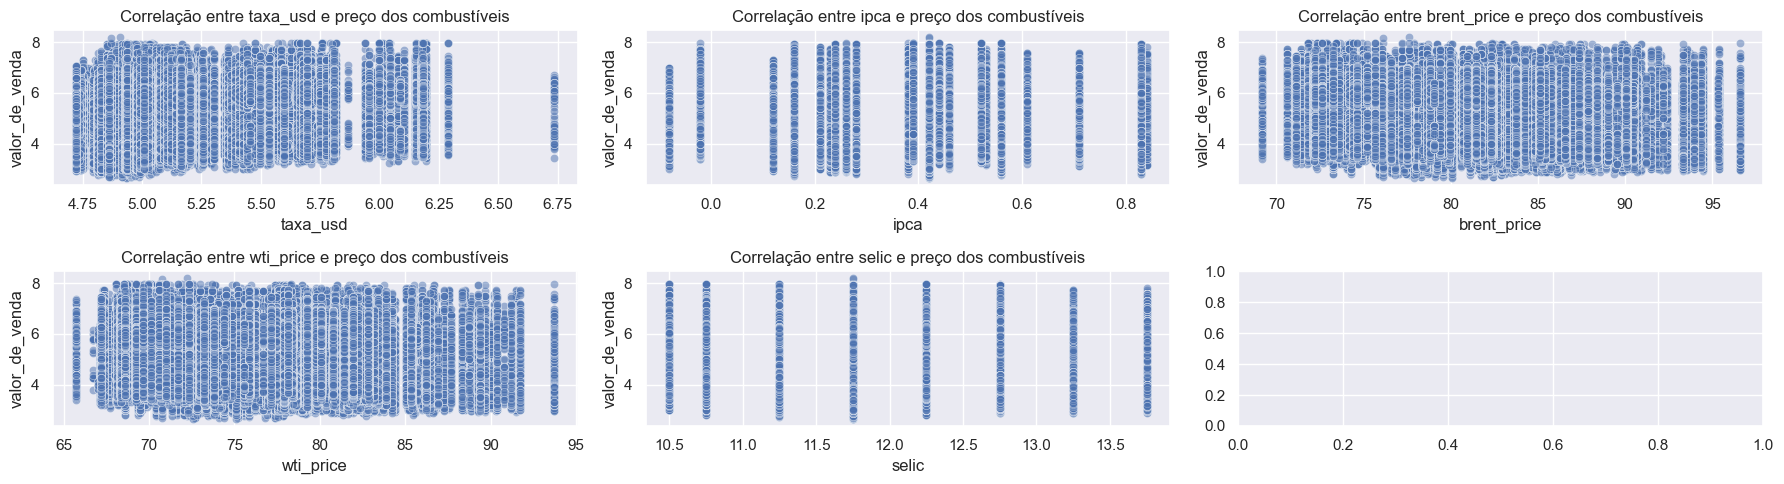

In [56]:
# Criando gr√°ficos de dispers√£o para analisar rela√ß√µes visuais
fig, axes = plt.subplots(2, 3, figsize=(18, 5))

variaveis_macro = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']
for i, var in enumerate(variaveis_macro):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(data=df_final_00, x=var, y='valor_de_venda', ax=ax, alpha=0.5)
    ax.set_title(f"Correla√ß√£o entre {var} e pre√ßo dos combust√≠veis")

plt.tight_layout()
plt.show()

### **3.2.2 Estat√≠sticas de Regress√£o Linear** 

A regress√£o linear simples permite quantificar o impacto de cada vari√°vel macroecon√¥mica nos pre√ßos dos combust√≠veis.

Interpreta√ß√£o dos coeficientes:

- Se o coeficiente for positivo, significa que quando a vari√°vel macroecon√¥mica sobe, o pre√ßo dos combust√≠veis tende a subir.
- Se for negativo, significa que o impacto √© inverso (exemplo: quando a SELIC sobe, os pre√ßos dos combust√≠veis podem cair).
- Quanto maior o valor absoluto do coeficiente, mais forte √© a influ√™ncia dessa vari√°vel.

In [57]:
# Criando uma tabela com estat√≠sticas descritivas
df_descriptive = df_final_00[['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']].describe()

# Exibindo no notebook
display(df_descriptive)

valor_de_venda    taxa_usd        ipca  brent_price   wti_price  \
count     491637.0000 491637.0000 491637.0000  491637.0000 491637.0000   
mean           5.2088      5.1675      0.3782      81.2309     76.8897   
std            0.9445      0.3292      0.2279       5.5466      5.6744   
min            2.6400      4.7239     -0.0800      69.1900     65.7500   
25%            4.3900      4.9335      0.2300      76.7100     72.1900   
50%            5.4900      5.0486      0.3800      81.9200     77.1000   
75%            5.9400      5.3668      0.5300      85.1800     80.8300   
max            8.1900      6.7324      0.8400      96.5500     93.6800   

            selic  
count 491637.0000  
mean      12.1368  
std        1.2996  
min       10.5000  
25%       10.7500  
50%       12.2500  
75%       13.7500  
max       13.7500

In [58]:
# Criando um dicion√°rio para armazenar os coeficientes
coef_dict = {}

# Rodando uma regress√£o linear para cada vari√°vel macroecon√¥mica
for var in ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']:
    X = sm.add_constant(df_final_00[var])  # Adicionando constante para o modelo
    y = df_final_00['valor_de_venda']
    
    model = sm.OLS(y, X).fit()
    coef_dict[var] = model.params[1]  # Pegando apenas o coeficiente da vari√°vel explicativa

# Criando uma tabela com os coeficientes
df_regression = pd.DataFrame.from_dict(coef_dict, orient='index', columns=['Coeficiente'])
df_regression.index.name = 'Vari√°vel Macroecon√¥mica'

# Exibindo no notebook
display(df_regression)

Coeficiente
Vari√°vel Macroecon√¥mica             
taxa_usd                      0.4271
ipca                          0.0869
brent_price                  -0.0032
wti_price                    -0.0003
selic                        -0.0983

### Conclus√£o Gr√°ficos de Dispers√£o e Quantifica√ß√£o da Rela√ß√£o (Regress√£o Linear) 

Os gr√°ficos de dispers√£o mostram tend√™ncias, mas a **regress√£o linear confirma que a taxa de c√¢mbio (USD/BRL) tem o maior impacto nos pre√ßos dos combust√≠veis**. 

---
# 4.0 Sele√ß√£o de Vari√°veis para Modelagem Preditiva

Antes de construir nosso modelo preditivo, precisamos avaliar quais vari√°veis **realmente contribuem para a previs√£o dos pre√ßos dos combust√≠veis**.

#### Objetivo
- Verificar se vari√°veis como `brent_price_lag1` e `brent_price_lag7` t√™m impacto na previs√£o.
- Testar a **correla√ß√£o** dessas vari√°veis com `valor_de_venda`.
- Rodar uma **Regress√£o Linear Inicial** com e sem os lags para comparar o desempenho.


## **4.1 Verificando a Correla√ß√£o das Vari√°veis**

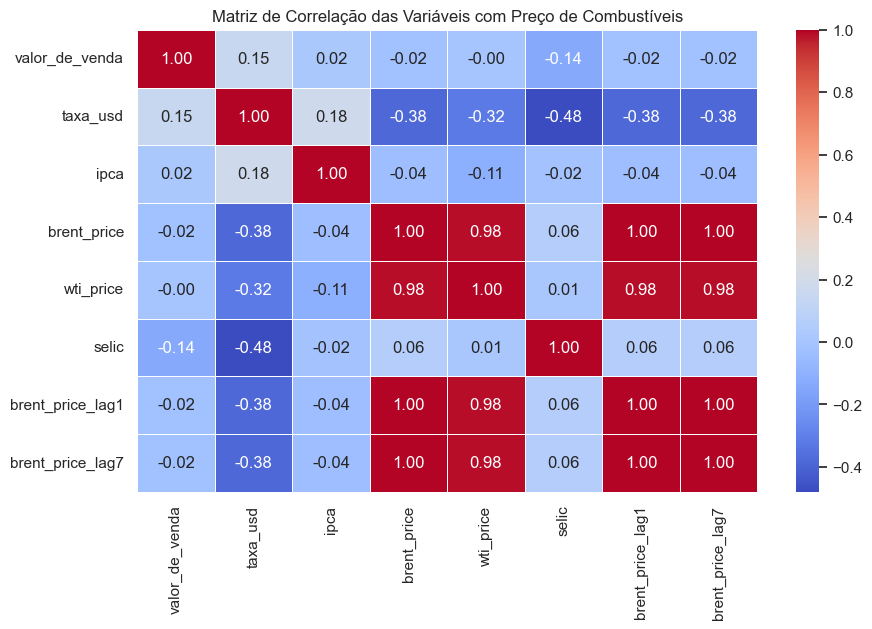

In [59]:
# Selecionando apenas as colunas relevantes para a correla√ß√£o
cols_corr = ['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic', 'brent_price_lag1', 'brent_price_lag7']

# Criando a matriz de correla√ß√£o
corr_matrix = df_final_00[cols_corr].corr()

# Criando um heatmap para visualizar a correla√ß√£o
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correla√ß√£o das Vari√°veis com Pre√ßo de Combust√≠veis")
plt.show()

Ap√≥s analisar a **correla√ß√£o das vari√°veis** e comparar modelos **com e sem os lags de `brent_price`**, chegamos √†s seguintes conclus√µes:

####  1. Conclus√£o Matriz de Correla√ß√£o
- `brent_price_lag1` e `brent_price_lag7` **t√™m correla√ß√£o muito baixa (-0.02) com `valor_de_venda`**, o que indica que **n√£o influenciam diretamente os pre√ßos dos combust√≠veis**.  
- Essas vari√°veis possuem **correla√ß√£o extremamente alta (1.00) com `brent_price`**, o que significa que elas **n√£o adicionam informa√ß√£o nova ao modelo** e podem gerar colinearidade.

## **4.2 Teste de Import√¢ncia das Vari√°veis (Feature Selection)**

Para garantir que as vari√°veis `brent_price_lag1` e `brent_price_lag7` s√£o √∫teis, rodamos um teste comparativo de regress√£o:

- 1Ô∏è. Modelo 1 (Sem Lags): Treinado com taxa_usd, ipca, brent_price, wti_price, selic.
- 2Ô∏è. Modelo 2 (Com Lags): Mesmo modelo, mas adicionando brent_price_lag1 e brent_price_lag7.
- 3Ô∏è. Compara√ß√£o dos resultados para decidir se os lags devem ser inclu√≠dos.

In [60]:
# Definindo as vari√°veis para cada teste
features_basico = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']
features_com_lag = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic', 'brent_price_lag1', 'brent_price_lag7']

In [61]:
# Rodando os dois modelos
result_basico = avaliar_modelo(features_basico, 'Regress√£o Linear (Sem Lags)')
result_com_lag = avaliar_modelo(features_com_lag, 'Regress√£o Linear (Com Lags)')

# Criando DataFrame de compara√ß√£o
df_comparacao = pd.DataFrame([result_basico, result_com_lag])

# Exibir a tabela comparativa
display(df_comparacao)

Modelo  R¬≤ Treino  R¬≤ Teste  RMSE Treino  RMSE Teste  \
0  Regress√£o Linear (Sem Lags)     0.0138   -0.0357       0.9299      0.9451   
1  Regress√£o Linear (Com Lags)     0.0138   -0.0357       0.9299      0.9451   

   MAE Treino  MAE Teste  
0      0.7886     0.8639  
1      0.7886     0.8639

#### 2. Conclus√£o Feature Selection
- **Os modelos apresentaram exatamente os mesmos resultados**, mostrando que os lags **n√£o contribuem para melhorar a previs√£o**.  
- **O R¬≤ de teste negativo (-0.0357)** indica que a Regress√£o Linear **n√£o est√° conseguindo capturar bem a rela√ß√£o entre as vari√°veis macroecon√¥micas e os pre√ßos dos combust√≠veis**.  
- **Os erros (RMSE e MAE) permaneceram iguais**, confirmando que os lags **n√£o adicionam valor preditivo**.


#### **Decis√£o Final**
‚úÖ **Removemos `brent_price_lag1` e `brent_price_lag7` da modelagem preditiva.**  
‚úÖ **Seguiremos apenas com as vari√°veis macroecon√¥micas (`taxa_usd`, `ipca`, `brent_price`, `wti_price`, `selic`).**  

---
# 5.0 Prepara√ß√£o dos Dados


In [62]:
df_model = df_final_00.copy()
display(df_model.head(3))

data_da_coleta regiao_sigla estado_sigla              municipio produto  \
0     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
1     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   
2     2023-01-02           CO           GO  AGUAS LINDAS DE GOIAS  DIESEL   

        bandeira  valor_de_venda   ano  mes  taxa_usd   ipca  brent_price  \
0         BRANCA          6.5900  2023    1    5.3633 0.5300      85.9100   
1         RAIZEN          6.5900  2023    1    5.3633 0.5300      85.9100   
2  VIBRA ENERGIA          6.6900  2023    1    5.3633 0.5300      85.9100   

   wti_price   selic  brent_price_lag1  brent_price_lag7  
0    80.2600 13.7500               NaN               NaN  
1    80.2600 13.7500           85.9100               NaN  
2    80.2600 13.7500           85.9100               NaN

# 6.0 Escalonamento (Rescaling)

In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

In [64]:
# Criar dicion√°rios para armazenar scalers e encoders
scalers = {
    "taxa_usd": RobustScaler(),
    "brent_price": RobustScaler(),
    "wti_price": RobustScaler(),
    "ipca": MinMaxScaler(),
    "selic": MinMaxScaler()
}

# Aplicar e salvar os scalers
for col, scaler in scalers.items():
    df_model[col] = scaler.fit_transform(df_model[[col]])  # Transformando os dados

# Salvar TODOS os scalers em um √∫nico arquivo
pickle.dump(scalers, open("../data/models/parameter/scalers.pkl", "wb"))

# 7.0 Codifica√ß√£o de Vari√°veis Categ√≥ricas (Encoding)

In [65]:
# Criar e salvar os LabelEncoders em um √∫nico dicion√°rio
encoders = {col: LabelEncoder() for col in ['regiao_sigla', 'estado_sigla', 'municipio', 'produto', 'bandeira']}
for col, le in encoders.items():
    df_model[col] = le.fit_transform(df_model[col])  # Transformando os dados

# Salvar TODOS os encoders em um √∫nico arquivo
pickle.dump(encoders, open("../data/models/parameter/encoders.pkl", "wb"))

In [66]:
print("‚úÖ Scalers e Encoders salvos corretamente!")

‚úÖ Scalers e Encoders salvos corretamente!


# 8.0 - Transforma√ß√£o da Vari√°vel Alvo

In [67]:
df_model['valor_de_venda'] = np.log1p(df_model['valor_de_venda'])

# üîπ 5.4 - Transforma√ß√µes C√≠clicas para Vari√°veis Temporais
df_model['mes_sin'] = np.sin(df_model['mes'] * (2. * np.pi / 12))
df_model['mes_cos'] = np.cos(df_model['mes'] * (2. * np.pi / 12))

df_model['dia_da_semana_sin'] = np.sin(df_model['data_da_coleta'].dt.dayofweek * (2. * np.pi / 7))
df_model['dia_da_semana_cos'] = np.cos(df_model['data_da_coleta'].dt.dayofweek * (2. * np.pi / 7))

df_model['semana_do_ano_sin'] = np.sin(df_model['data_da_coleta'].dt.isocalendar().week * (2. * np.pi / 52))
df_model['semana_do_ano_cos'] = np.cos(df_model['data_da_coleta'].dt.isocalendar().week * (2. * np.pi / 52))


# 9.0 - Remover colunas desnecess√°rias

In [68]:
df_model.drop(columns=['brent_price_lag1', 'brent_price_lag7'], inplace=True)

In [69]:
# ‚úÖ Exibir 5 amostras para confer√™ncia
display(df_model.head(3))

data_da_coleta  regiao_sigla  estado_sigla  municipio  produto  bandeira  \
0     2023-01-02             0             8          3        0         6   
1     2023-01-02             0             8          3        0        28   
2     2023-01-02             0             8          3        0        51   

   valor_de_venda   ano  mes  taxa_usd   ipca  brent_price  wti_price  selic  \
0          2.0268  2023    1    0.7263 0.6630       0.4711     0.3657 1.0000   
1          2.0268  2023    1    0.7263 0.6630       0.4711     0.3657 1.0000   
2          2.0399  2023    1    0.7263 0.6630       0.4711     0.3657 1.0000   

   mes_sin  mes_cos  dia_da_semana_sin  dia_da_semana_cos  semana_do_ano_sin  \
0   0.5000   0.8660             0.0000             1.0000             0.1205   
1   0.5000   0.8660             0.0000             1.0000             0.1205   
2   0.5000   0.8660             0.0000             1.0000             0.1205   

   semana_do_ano_cos  
0             0.9927  
1             0.9927  
2             0.9927

### Separa√ß√£o Treino/Teste

In [70]:
# Converter a data corretamente
df_model['data_da_coleta'] = pd.to_datetime(df_model['data_da_coleta'])

# Definir X (features) e y (target)
X = df_model.drop(columns=['valor_de_venda', 'data_da_coleta', 'ano', 'mes'])  # Removendo a vari√°vel alvo e dados temporais
y = df_model['valor_de_venda']

# Divis√£o entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Conferir dimens√µes
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (393309, 16), X_test: (98328, 16)
y_train: (393309,), y_test: (98328,)


---
### Treinar o modelo de Regress√£o Linear (Baseline)

In [71]:
# Instanciar o modelo
modelo_lr = LinearRegression()

# Treinar o modelo
modelo_lr.fit(X_train, y_train)

# Fazer previs√µes
y_train_pred = modelo_lr.predict(X_train)
y_test_pred = modelo_lr.predict(X_test)

# Avalia√ß√£o do modelo
def avaliar_modelo(y_true, y_pred, nome):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Modelo": nome, "R¬≤": r2, "RMSE": rmse, "MAE": mae}

# Avalia√ß√£o nos dois conjuntos
result_treino = avaliar_modelo(y_train, y_train_pred, "Regress√£o Linear (Treino)")
result_teste = avaliar_modelo(y_test, y_test_pred, "Regress√£o Linear (Teste)")

df_resultados = pd.DataFrame([result_treino, result_teste])

# Exibir resultados
display(df_resultados)


Modelo     R¬≤   RMSE    MAE
0  Regress√£o Linear (Treino) 0.0367 0.1579 0.1339
1   Regress√£o Linear (Teste) 0.0279 0.1492 0.1343

---
### Treinar e Avaliar o Random Forest

In [72]:
# Instanciar o modelo
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Treinar o modelo
modelo_rf.fit(X_train, y_train)

# Fazer previs√µes
y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

# Avalia√ß√£o do modelo
result_treino_rf = avaliar_modelo(y_train, y_train_pred, "Random Forest (Treino)")
result_teste_rf = avaliar_modelo(y_test, y_test_pred, "Random Forest (Teste)")

# Criar DataFrame de resultados
df_resultados_rf = pd.DataFrame([result_treino_rf, result_teste_rf])

# Exibir resultados
display(df_resultados_rf)


Modelo     R¬≤   RMSE    MAE
0  Random Forest (Treino) 0.9971 0.0087 0.0055
1   Random Forest (Teste) 0.8025 0.0672 0.0503

---
### Treinar e Avaliar o XGBoost

In [73]:
# Instanciar o modelo
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Treinar o modelo
modelo_xgb.fit(X_train, y_train)

# Fazer previs√µesavaliar_modelo
y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

# Avalia√ß√£o do modelo
result_treino_xgb = avaliar_modelo(y_train, y_train_pred, "XGBoost (Treino)")
result_teste_xgb = avaliar_modelo(y_test, y_test_pred, "XGBoost (Teste)")

# Criar DataFrame de resultados
df_resultados_xgb = pd.DataFrame([result_treino_xgb, result_teste_xgb])

# Exibir resultados
display(df_resultados_xgb)


Modelo     R¬≤   RMSE    MAE
0  XGBoost (Treino) 0.9420 0.0387 0.0293
1   XGBoost (Teste) 0.8474 0.0591 0.0467

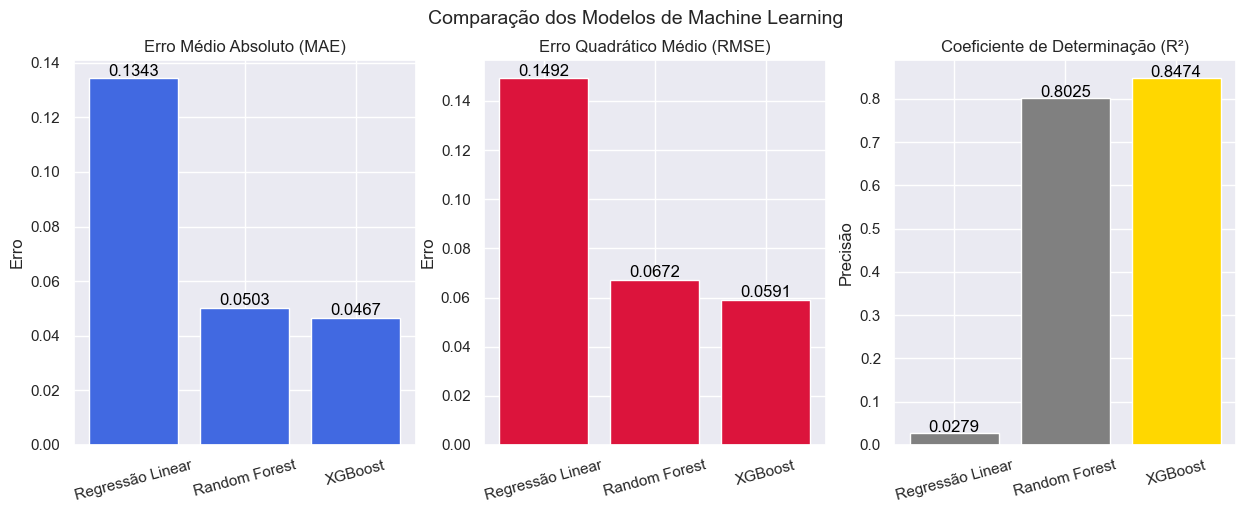

In [74]:
# Concatenar os DataFrames em um √∫nico
df_comparacao = pd.concat([
    df_resultados[df_resultados["Modelo"].str.contains("Teste")].assign(Algoritmo="Regress√£o Linear"),
    df_resultados_rf[df_resultados_rf["Modelo"].str.contains("Teste")].assign(Algoritmo="Random Forest"),
    df_resultados_xgb[df_resultados_xgb["Modelo"].str.contains("Teste")].assign(Algoritmo="XGBoost")
])

# Criar listas com os valores extra√≠dos dos DataFrames
modelos = df_comparacao["Algoritmo"].tolist()
r2 = df_comparacao["R¬≤"].tolist()
rmse = df_comparacao["RMSE"].tolist()
mae = df_comparacao["MAE"].tolist()

# Criar os gr√°ficos
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Gr√°fico MAE
ax[0].bar(modelos, mae, color="royalblue")
ax[0].set_title("Erro M√©dio Absoluto (MAE)")
ax[0].set_ylabel("Erro")

# Gr√°fico RMSE
ax[1].bar(modelos, rmse, color="crimson")
ax[1].set_title("Erro Quadr√°tico M√©dio (RMSE)")
ax[1].set_ylabel("Erro")

# Identificar o melhor modelo (maior R¬≤) e destacar
melhor_modelo = modelos[r2.index(max(r2))]
colors = ["gray" if m != melhor_modelo else "gold" for m in modelos]

# Gr√°fico R¬≤ com destaque para o melhor modelo
ax[2].bar(modelos, r2, color=colors)
ax[2].set_title("Coeficiente de Determina√ß√£o (R¬≤)")
ax[2].set_ylabel("Precis√£o")

# Ajustar r√≥tulos do eixo X para melhor legibilidade
for a in ax:
    a.set_xticklabels(modelos, rotation=15)  # Inclina os r√≥tulos

# Adicionar os valores exatos sobre as barras
for i, v in enumerate(mae):
    ax[0].text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=12, color="black")

for i, v in enumerate(rmse):
    ax[1].text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=12, color="black")

for i, v in enumerate(r2):
    ax[2].text(i, v + 0.002, f"{v:.4f}", ha='center', fontsize=12, color="black")

# Definir um t√≠tulo geral para os gr√°ficos
plt.suptitle("Compara√ß√£o dos Modelos de Machine Learning", fontsize=14)

# Exibir os gr√°ficos
plt.show()


---
## Otimiza√ß√£o do Modelo

### Otimiza√ß√£o com RandomizedSearchCV

In [75]:
# Defini√ß√£o do modelo base
modelo_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Defini√ß√£o dos hiperpar√¢metros a serem testados
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Configura√ß√£o da busca aleat√≥ria
random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=param_grid,
    n_iter=20,  # N√∫mero de combina√ß√µes a testar
    scoring='neg_mean_absolute_error',  # M√©trica de otimiza√ß√£o
    cv=3,  # Valida√ß√£o cruzada com 3 divis√µes
    verbose=2,
    n_jobs=-1
)

# Executar a busca pelos melhores hiperpar√¢metros
random_search.fit(X_train, y_train)

# Exibir os melhores par√¢metros encontrados
print("Melhores hiperpar√¢metros:", random_search.best_params_)

# Treinar o modelo final com os melhores hiperpar√¢metros
melhores_params = random_search.best_params_
modelo_xgb_otimizado = XGBRegressor(**melhores_params, objective='reg:squarederror', random_state=42)
modelo_xgb_otimizado.fit(X_train, y_train)

# Fazer previs√µes
y_train_pred = modelo_xgb_otimizado.predict(X_train)
y_test_pred = modelo_xgb_otimizado.predict(X_test)

# Avalia√ß√£o do modelo otimizado
result_treino_xgb_opt = avaliar_modelo(y_train, y_train_pred, "XGBoost Otimizado (Treino)")
result_teste_xgb_opt = avaliar_modelo(y_test, y_test_pred, "XGBoost Otimizado (Teste)")

# Criar DataFrame de resultados
df_resultados_xgb_opt = pd.DataFrame([result_treino_xgb_opt, result_teste_xgb_opt])

# Exibir resultados
display(df_resultados_xgb_opt)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores hiperpar√¢metros: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


Modelo     R¬≤   RMSE    MAE
0  XGBoost Otimizado (Treino) 0.9806 0.0224 0.0159
1   XGBoost Otimizado (Teste) 0.8507 0.0585 0.0478

In [76]:
# Caminho do arquivo para salvar o modelo
model_path = os.path.join(model_dir, "modelo_xgb_otimizado.pkl")

# Salvar o modelo treinado
with open(model_path, "wb") as f:
    pickle.dump(modelo_xgb_otimizado, f)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: ../data/models/modelo_xgb_otimizado.pkl


---
# 10.0 Refinamento Final do Modelo

## An√°lise de Interpretabilidade com SHAP Values

**Objetivo:** Entender quais vari√°veis mais influenciam o pre√ßo dos combust√≠veis.

In [ ]:
# Converter X_train para float16 para reduzir uso de mem√≥ria
X_train = X_train.astype('float32')

# Reduzir tamanho da amostra para SHAP (m√°ximo de 5000 amostras para acelerar)
sample_size = min(5000, X_train.shape[0])
X_train_sample = X_train.sample(sample_size, random_state=42)

# Utilizar TreeExplainer diretamente para XGBoost (sem n_jobs)
explainer = shap.TreeExplainer(modelo_xgb_otimizado)
shap_values = explainer.shap_values(X_train_sample)

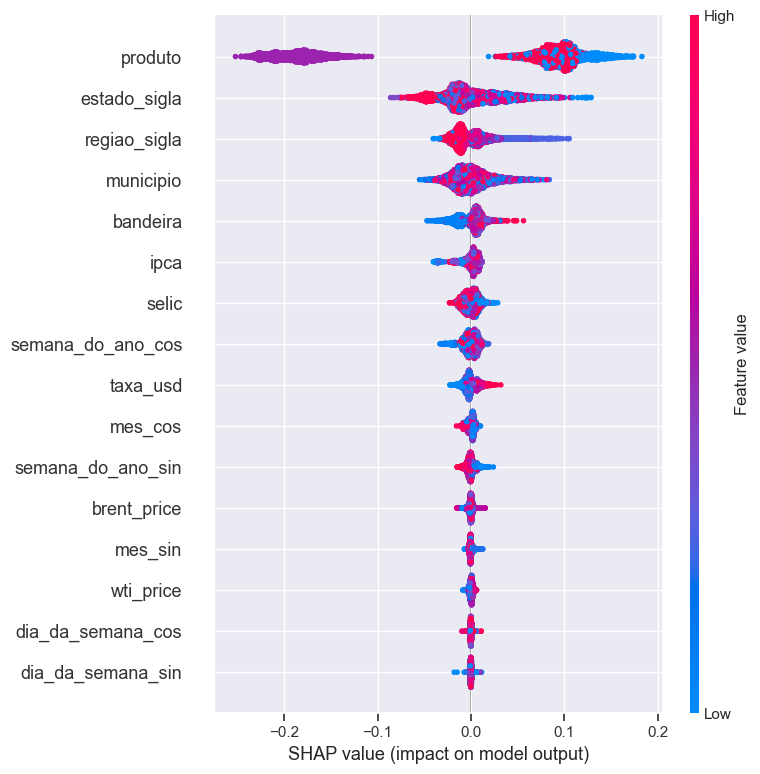

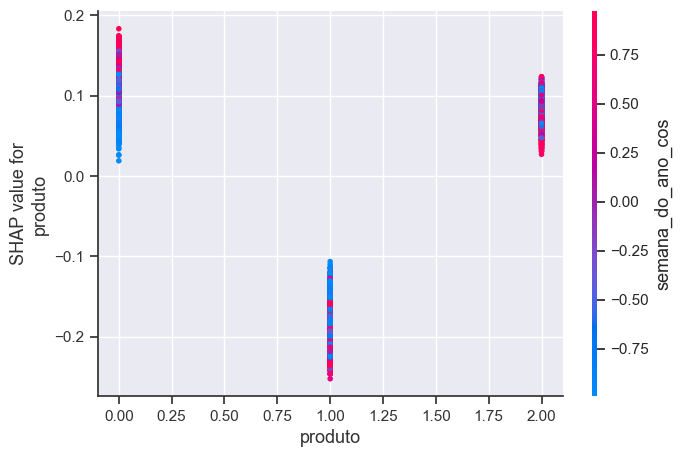

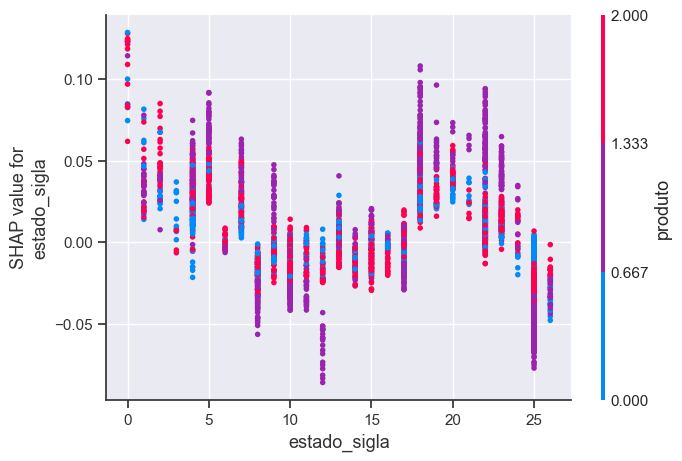

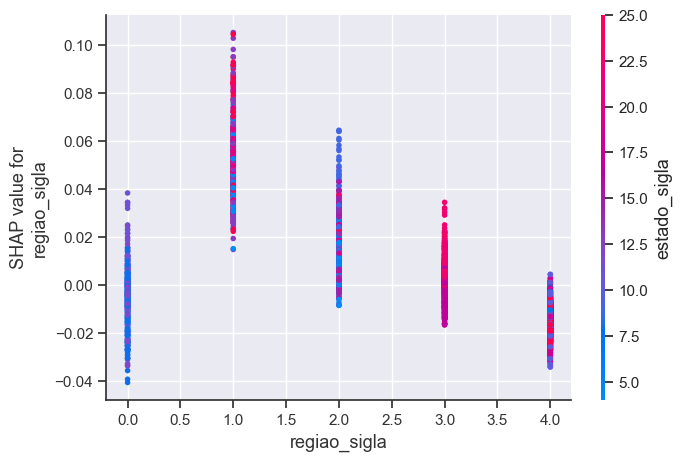

Feature  SHAP Mean
3             produto     0.1286
1        estado_sigla     0.0246
0        regiao_sigla     0.0148
2           municipio     0.0147
4            bandeira     0.0098
6                ipca     0.0060
9               selic     0.0059
15  semana_do_ano_cos     0.0056
5            taxa_usd     0.0054
11            mes_cos     0.0031
14  semana_do_ano_sin     0.0031
7         brent_price     0.0015
10            mes_sin     0.0013
8           wti_price     0.0013
13  dia_da_semana_cos     0.0006
12  dia_da_semana_sin     0.0006

In [78]:
# Gr√°fico de Import√¢ncia das Features (Resumo Global)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_sample)

# Valores M√©dios de SHAP (Impacto de cada vari√°vel)
shap_df = pd.DataFrame({"Feature": X_train_sample.columns, "SHAP Mean": np.abs(shap_values).mean(axis=0)})
shap_df = shap_df.sort_values("SHAP Mean", ascending=False)

# Gr√°fico de Depend√™ncia Parcial para as 3 Vari√°veis Mais Importantes
top_features = shap_df["Feature"].head(3).tolist()
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_train_sample)

# Exibir os valores m√©dios de SHAP
display(shap_df)

### üìä An√°lise dos Valores SHAP: Impacto das Vari√°veis na Previs√£o dos Pre√ßos dos Combust√≠veis  

Os gr√°ficos e a tabela de valores SHAP fornecem **insights sobre a import√¢ncia de cada vari√°vel** no modelo XGBoost, permitindo entender **quais fatores mais influenciam os pre√ßos dos combust√≠veis**.  

---

#### **1. Principais Vari√°veis que Impactam os Pre√ßos (Valores SHAP)**  

**Vari√°vel mais influente:** **Produto (0.1286)**  
‚úÖ A **principal vari√°vel para previs√£o dos pre√ßos** √© o tipo de combust√≠vel (**Diesel, Gasolina ou Etanol**).  
‚úÖ Isso faz sentido, pois **cada produto tem sua pr√≥pria din√¢mica de precifica√ß√£o**.  

**Outras vari√°veis relevantes:**  
‚úÖ **Estado (0.0246) e Regi√£o (0.0148)** ‚Üí O local de venda influencia os pre√ßos, devido a **diferen√ßas tribut√°rias, log√≠sticas e concorr√™ncia**.  
‚úÖ **Munic√≠pio (0.0147)** ‚Üí Impacto significativo, refor√ßando a import√¢ncia das **varia√ß√µes locais na precifica√ß√£o**.  
‚úÖ **Bandeira (0.0098)** ‚Üí Postos de bandeira branca e bandeirados possuem diferen√ßas de pre√ßos devido a negocia√ß√µes com distribuidoras.  

---

#### **2. Impacto de Indicadores Econ√¥micos (Menor Influ√™ncia no Curto Prazo)**  

üî∏ **IPCA (0.0060) e SELIC (0.0059)** ‚Üí Pequena influ√™ncia, indicando que a infla√ß√£o e os juros **afetam pre√ßos de forma indireta**.  
üî∏ **Taxa de c√¢mbio (USD/BRL) (0.0054)** ‚Üí Impacto baixo, sugerindo que o c√¢mbio **n√£o se reflete diretamente no curto prazo**.  
üî∏ **Pre√ßos do petr√≥leo (Brent e WTI)** ‚Üí **Correla√ß√£o muito fraca com os pre√ßos dos combust√≠veis no Brasil**, refor√ßando que o **repasse das varia√ß√µes do petr√≥leo n√£o ocorre de forma imediata**.  

---

#### **3. Influ√™ncia da Temporalidade (Ciclo Semanal e Sazonalidade)**  

‚úÖ **Semana do ano (0.0056)** e **M√™s (0.0031 - 0.0031)** ‚Üí Pequena influ√™ncia da sazonalidade anual, mas n√£o √© um fator determinante.  
‚úÖ **Dia da Semana (0.0006 - 0.0006)** ‚Üí Praticamente insignificante, indicando que **n√£o h√° uma tend√™ncia clara de flutua√ß√£o di√°ria nos pre√ßos**.  

---

#### **Conclus√µes e Pr√≥ximos Passos**  

- **O pre√ßo dos combust√≠veis √© fortemente influenciado pelo tipo de produto e localiza√ß√£o (estado, munic√≠pio e regi√£o).**  
- **Fatores macroecon√¥micos, como c√¢mbio e petr√≥leo, t√™m impacto reduzido no curto prazo**, possivelmente devido √† pol√≠tica de precifica√ß√£o no Brasil.  
- **Sazonalidade e fatores temporais n√£o afetam significativamente os pre√ßos**, indicando que a volatilidade do mercado pode estar mais associada a pol√≠ticas governamentais e demanda local.  

---
# 11.0 Valida√ß√£o Cruzada Temporal (Time Series Cross-Validation)

**Objetivo:** Avaliar a estabilidade do modelo ao longo do tempo.

- Como lidamos com s√©ries temporais, precisamos garantir que o modelo realmente prev√™ bem novos per√≠odos.
- Vamos aplicar Time Series Cross-Validation, que evita vazamento de dados do futuro para o passado.

In [79]:
# Configurar valida√ß√£o cruzada temporal (5 divis√µes)
tscv = TimeSeriesSplit(n_splits=5)

# Lista para armazenar resultados
resultados_cv = []

# Rodar valida√ß√£o cruzada
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Treinar modelo XGBoost otimizado
    modelo_xgb_cv = XGBRegressor(**melhores_params, objective='reg:squarederror', random_state=42)
    modelo_xgb_cv.fit(X_train_cv, y_train_cv)

    # Fazer previs√µes
    y_pred_cv = modelo_xgb_cv.predict(X_test_cv)

    # Avaliar desempenho
    resultado = avaliar_modelo(y_test_cv, y_pred_cv, f"XGBoost (Fold {len(resultados_cv) + 1})")
    resultados_cv.append(resultado)

# Criar DataFrame com os resultados
df_resultados_cv = pd.DataFrame(resultados_cv)

# Exibir resultados
display(df_resultados_cv)


Modelo     R¬≤   RMSE    MAE
0  XGBoost (Fold 1) 0.5212 0.0864 0.0614
1  XGBoost (Fold 2) 0.8795 0.0583 0.0470
2  XGBoost (Fold 3) 0.8693 0.0652 0.0535
3  XGBoost (Fold 4) 0.9208 0.0503 0.0405
4  XGBoost (Fold 5) 0.8469 0.0619 0.0480

- **Fold 4 teve o melhor desempenho geral**, com **R¬≤ de 0.9208, RMSE de 0.0503 e MAE de 0.0405**, indicando **baixa margem de erro e alta precis√£o**.  
- **Fold 2 e Fold 3 tamb√©m apresentaram bons resultados**, com **R¬≤ acima de 0.85** e erros relativamente baixos.  
- **Fold 1 apresentou o menor desempenho (R¬≤ = 0.5212)**, sugerindo que pode ter sido um subconjunto mais dif√≠cil de prever, possivelmente devido a alguma anomalia nos dados ou maior volatilidade nos pre√ßos.  
- **A varia√ß√£o entre os folds sugere que h√° diferen√ßas na previsibilidade ao longo do tempo**, refor√ßando a import√¢ncia de **valida√ß√£o cruzada temporal** para garantir um modelo mais robusto.  


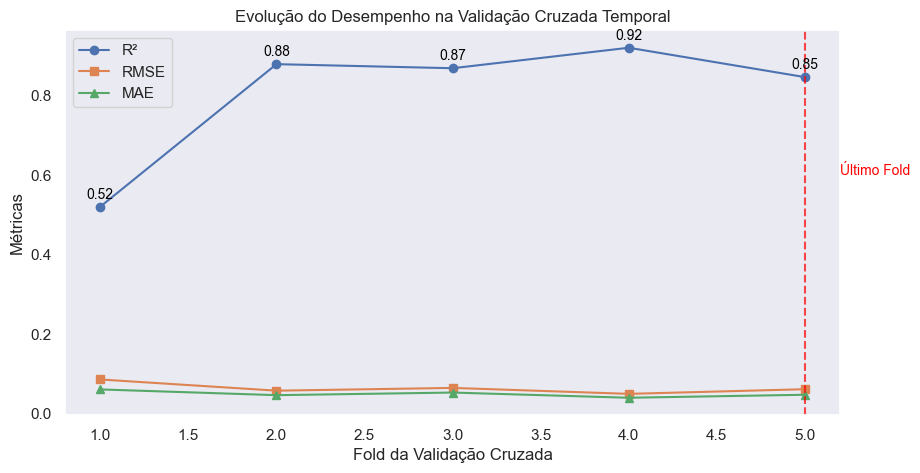

In [80]:
# Criar gr√°fico para mostrar a varia√ß√£o das m√©tricas nos diferentes folds
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["R¬≤"], marker="o", label="R¬≤")
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["RMSE"], marker="s", label="RMSE")
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["MAE"], marker="^", label="MAE")

for i, v in enumerate(df_resultados_cv["R¬≤"]):
    plt.text(i+1, v + 0.02, f"{v:.2f}", ha="center", fontsize=10, color="black")

plt.axvline(x=5, color="red", linestyle="--", alpha=0.7)  # Linha vermelha destacando o Fold 5
plt.text(5.2, 0.6, "√öltimo Fold", color="red", fontsize=10)


plt.xlabel("Fold da Valida√ß√£o Cruzada")
plt.ylabel("M√©tricas")
plt.title("Evolu√ß√£o do Desempenho na Valida√ß√£o Cruzada Temporal")
plt.legend()
plt.grid()
plt.show()


---
# 12.0 An√°lises Finais e Conclus√£o do Projeto

**Avalia√ß√£o do Erro Percentual M√©dio (MPE)**

O Erro Percentual M√©dio (MPE) avalia o qu√£o pr√≥ximas est√£o as previs√µes dos valores reais.

In [81]:
# Aplicar a fun√ß√£o para avaliar o erro percentual
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_test_pred))
print(f"Erro Percentual M√©dio (MPE): {mpe:.4f}")

Erro Percentual M√©dio (MPE): 0.0404


## 12.1 Compara√ß√£o entre Pre√ßos Reais e Previstos

In [82]:
# Criar um DataFrame para an√°lises finais
# Copia os dados de teste originais
df_final = X_test.copy()  

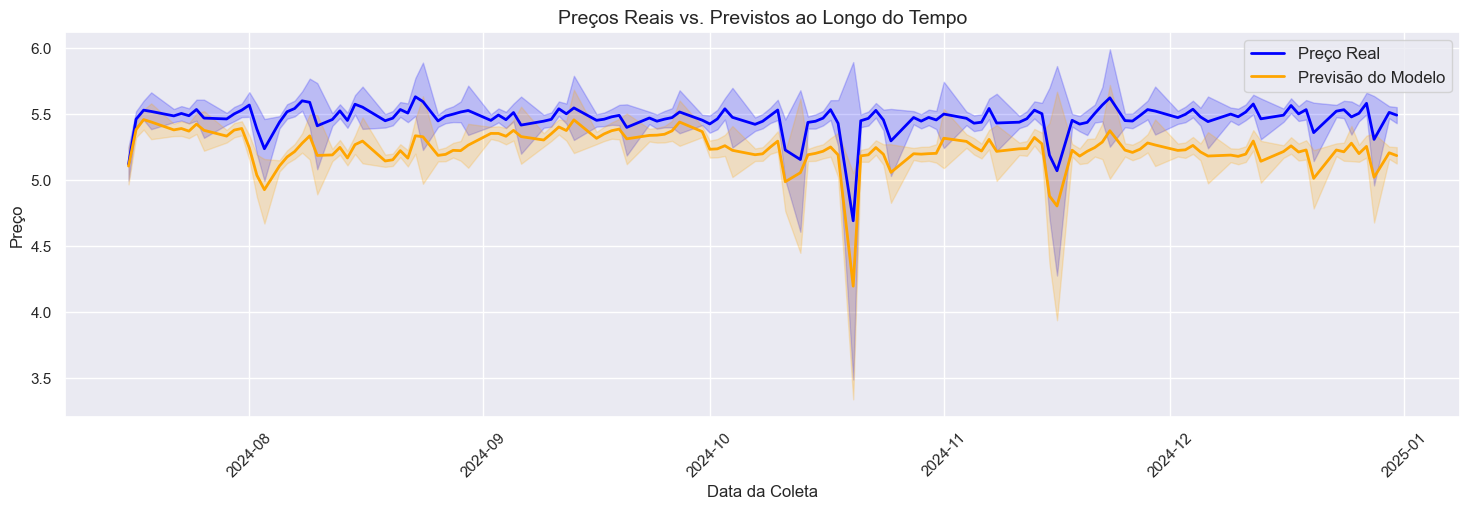

In [83]:
df_final['preco_real'] = np.expm1(y_test)  # Reverter log1p nos pre√ßos reais
df_final['previsao'] = np.expm1(y_test_pred)  # Reverter log1p nas previs√µes

# Adicionar a coluna de data ao df_final se ela existir no dataset original
df_final['data_da_coleta'] = df_final_00.loc[X_test.index, 'data_da_coleta']

plt.figure(figsize=(18, 5))

# Compara√ß√£o entre pre√ßos reais e previstos
sns.lineplot(x=df_final['data_da_coleta'], y=df_final['preco_real'], label="Pre√ßo Real", linewidth=2, color="blue")
sns.lineplot(x=df_final['data_da_coleta'], y=df_final['previsao'], label="Previs√£o do Modelo", linewidth=2, color="orange")

# Melhorando a apresenta√ß√£o
plt.title("Pre√ßos Reais vs. Previstos ao Longo do Tempo", fontsize=14)
plt.xlabel("Data da Coleta", fontsize=12)
plt.ylabel("Pre√ßo", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

plt.show()


O gr√°fico compara os pre√ßos reais dos combust√≠veis (linha azul) com as previs√µes do modelo (linha laranja), incluindo faixas de incerteza.

Observa√ß√µes:

- O modelo acompanha bem a tend√™ncia geral dos pre√ßos, mostrando boa estabilidade e baixa variabilidade.
- Existem alguns momentos de subestima√ß√£o ou superestima√ß√£o dos pre√ßos, especialmente em quedas bruscas.
- Os maiores desvios acontecem em momentos de varia√ß√µes at√≠picas, indicando que eventos externos (como mudan√ßas na pol√≠tica de pre√ßos) podem impactar a precis√£o.

## 12.2 Avalia√ß√£o do Desempenho por Produto e Estado

In [84]:
# Carregar os encoders salvos
encoders = pickle.load(open("../data/models/parameter/encoders.pkl", "rb"))

# Carregar os scalers salvos
scalers = pickle.load(open("../data/models/parameter/scalers.pkl", "rb"))

# Criar mapeamento reverso
for col, le in encoders.items():
    df_final[col] = le.inverse_transform(df_final[col])

# Reverter os valores para a escala original
for col, scaler in scalers.items():
    df_final[col] = scaler.inverse_transform(df_final[[col]])

In [85]:
# Criar os dados de an√°lise
df_analise = df_final.copy()

In [86]:
# Calcular MAE e MAPE para cada combina√ß√£o de estado e produto
df_mae = df_analise.groupby(['estado_sigla', 'produto']).apply(
    lambda x: mean_absolute_error(x['preco_real'], x['previsao'])
).reset_index().rename(columns={0: 'MAE'})

df_mape = df_analise.groupby(['estado_sigla', 'produto']).apply(
    lambda x: mean_absolute_percentage_error(x['preco_real'], x['previsao'])
).reset_index().rename(columns={0: 'MAPE'})

# Calcular a m√©dia das previs√µes por estado e produto
df_previsoes = df_analise.groupby(['estado_sigla', 'produto'])[['previsao']].mean().reset_index()

# Mesclar as m√©tricas no mesmo dataframe
df_resultados = df_previsoes.merge(df_mae, on=['estado_sigla', 'produto'])
df_resultados = df_resultados.merge(df_mape, on=['estado_sigla', 'produto'])

# Definir cen√°rios otimista e pessimista
df_resultados['worst_scenario'] = df_resultados['previsao'] - df_resultados['MAE']
df_resultados['best_scenario'] = df_resultados['previsao'] + df_resultados['MAE']

# Reorganizar colunas para visualiza√ß√£o
df_resultados = df_resultados[['estado_sigla', 'produto', 'previsao', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [87]:
# Exibir os estados e produtos com maior MAPE (erro percentual)
df_resultados.sort_values(by='MAPE', ascending=False, inplace=True)

# Exibir a tabela com os 10 estados/produtos com maior erro percentual
print("Erros por Estado e Produto")
display(df_resultados.head(10))

Erros por Estado e Produto


estado_sigla   produto  previsao  worst_scenario  best_scenario    MAE  \
8            AM  GASOLINA    6.2643          5.4656         7.0630 0.7987   
65           RR  GASOLINA    5.9385          5.2140         6.6631 0.7246   
62           RO  GASOLINA    6.2557          5.5612         6.9502 0.6945   
80           TO  GASOLINA    5.8494          5.2603         6.4386 0.5892   
7            AM    ETANOL    4.4795          4.0326         4.9263 0.4469   
2            AC  GASOLINA    6.7809          6.1448         7.4170 0.6361   
23           ES  GASOLINA    5.8281          5.3375         6.3187 0.4906   
58           RN    ETANOL    4.8466          4.4956         5.1976 0.3510   
31           MG    ETANOL    3.9050          3.5897         4.2202 0.3153   
25           GO    ETANOL    3.8407          3.5322         4.1492 0.3085   

     MAPE  
8  0.1129  
65 0.1072  
62 0.0987  
80 0.0910  
7  0.0899  
2  0.0857  
23 0.0774  
58 0.0743  
31 0.0736  
25 0.0733

A tabela mostra os maiores erros absolutos (MAE) e percentuais (MAPE) por estado e produto.

**Estados com maior erro percentual:**
- Amazonas (AM) e Roraima (RR) apresentam os maiores erros para Gasolina, refor√ßando a dificuldade do modelo em prever corretamente nessas regi√µes.
- Estados do Sudeste (ES, MG, GO) t√™m erros menores, indicando maior estabilidade nos pre√ßos.

**Poss√≠veis Explica√ß√µes:**
- Estados do Norte e Nordeste enfrentam desafios log√≠sticos e tribut√°rios, tornando os pre√ßos mais vol√°teis e dif√≠ceis de prever.
- A Gasolina tem maior erro em estados com menos concorr√™ncia ou alta depend√™ncia de importa√ß√£o.
- O Etanol √© mais vol√°til devido √† influ√™ncia da safra da cana-de-a√ß√∫car, o que pode dificultar previs√µes em estados com baixa produ√ß√£o interna.

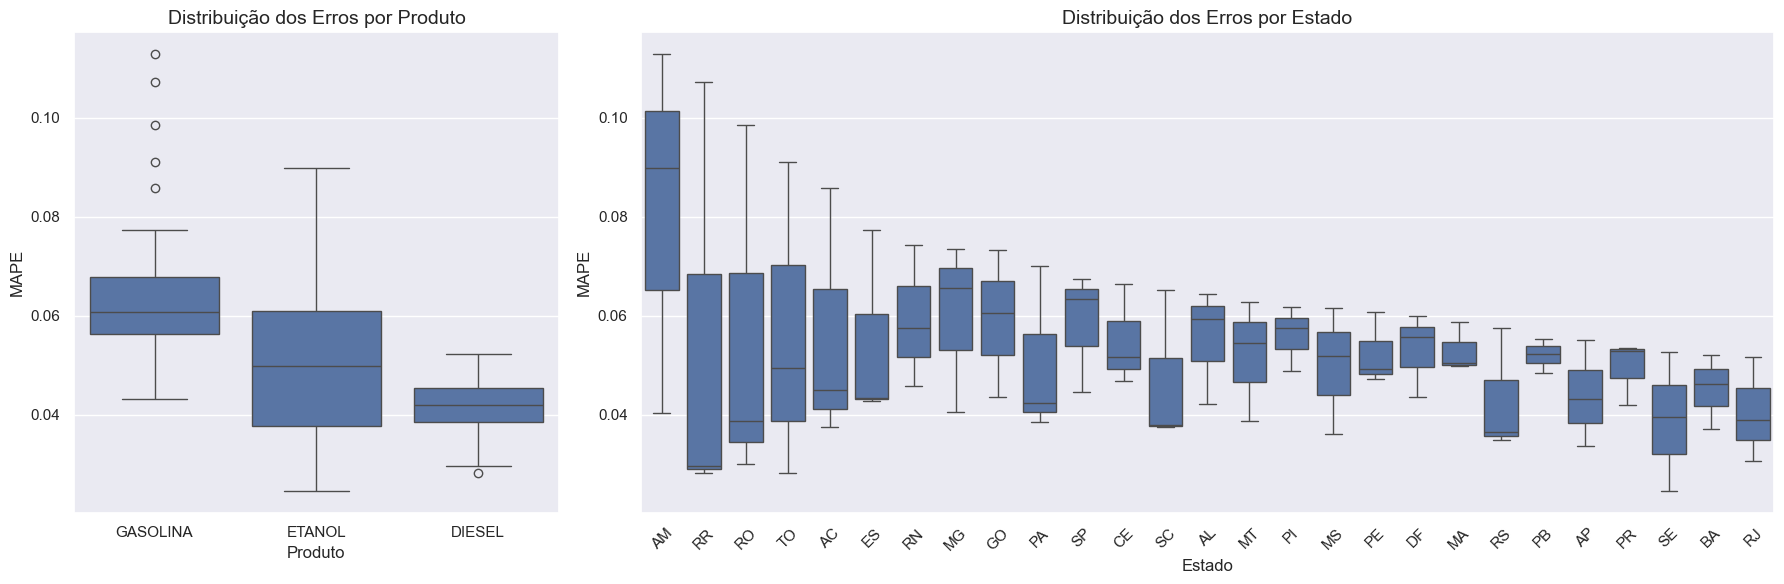

In [88]:
# üìä Criar a figura com dois gr√°ficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [0.3, 0.7]})

# Boxplot dos erros por Produto
sns.boxplot(x="produto", y="MAPE", data=df_resultados, ax=axes[0])
axes[0].set_title("Distribui√ß√£o dos Erros por Produto", fontsize=14)
axes[0].set_xlabel("Produto", fontsize=12)
axes[0].set_ylabel("MAPE", fontsize=12)

# Boxplot dos erros por Estado
sns.boxplot(x="estado_sigla", y="MAPE", data=df_resultados, ax=axes[1])
axes[1].set_title("Distribui√ß√£o dos Erros por Estado", fontsize=14)
axes[1].set_xlabel("Estado", fontsize=12)
axes[1].set_ylabel("MAPE", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)  # Rotacionar os r√≥tulos dos estados

# Ajustar espa√ßamento e exibir o gr√°fico
plt.tight_layout()
plt.show()

**Erros por Produto (Boxplot Esquerdo)**
- Diesel apresenta os menores erros (MAPE mais baixo e menos dispers√£o), sugerindo que o modelo consegue prever esse combust√≠vel com mais precis√£o.
- Etanol tem maior variabilidade nos erros, possivelmente devido √† influ√™ncia de fatores sazonais (safra e entressafra).
- Gasolina apresenta alguns outliers, indicando que em alguns momentos o modelo teve dificuldades em prever corretamente.

**Erros por Estado (Boxplot Direito)**
- Estados como Amazonas (AM), Roraima (RR) e Rond√¥nia (RO) apresentam erros mais elevados, possivelmente devido a varia√ß√µes regionais nos pre√ßos e menor disponibilidade de dados.
- Estados do Sudeste e Sul tendem a ter erros menores, indicando maior previsibilidade nos pre√ßos dos combust√≠veis nessas regi√µes.

---
# Conclus√£o e Pr√≥ximos Passos

### **Principais Resultados**  
O modelo **XGBoost** demonstrou **boa precis√£o** na previs√£o dos pre√ßos dos combust√≠veis, com **m√©tricas de erro baixas e estabilidade ao longo do tempo**. Em compara√ß√£o com modelos mais simples, como **Regress√£o Linear e Random Forest**, o XGBoost se destacou pela capacidade de capturar varia√ß√µes nos pre√ßos sem superajustar os dados.  

### **Impacto e Aplica√ß√£o**  
A previs√£o precisa dos pre√ßos dos combust√≠veis pode trazer **benef√≠cios diretos para diferentes p√∫blicos**:  
- **Consumidores finais:** Auxilia na escolha do melhor momento para abastecer, reduzindo gastos.  
- **Empresas de transporte e log√≠stica:** Permite **planejamento financeiro mais eficiente** e redu√ß√£o do impacto de varia√ß√µes nos pre√ßos.  
- **Postos de combust√≠veis e revendedores:** Facilita **ajustes estrat√©gicos** nos pre√ßos, melhorando competitividade.  

### üöÄ **Pr√≥ximos Passos**  
Para aprimorar ainda mais o projeto, os seguintes passos ser√£o implementados:  
‚úÖ **Otimiza√ß√£o da coleta de dados** ‚Äì Incluir novas vari√°veis relevantes, como oferta/demanda, estoques e indicadores econ√¥micos mais detalhados.  
‚úÖ **Desenvolvimento de um aplicativo interativo (Streamlit)** ‚Äì Criar uma interface acess√≠vel para que usu√°rios possam visualizar previs√µes de forma intuitiva.  
‚úÖ **Implementa√ß√£o de alertas automatizados** ‚Äì Integrar notifica√ß√µes via **API ou Telegram**, permitindo atualiza√ß√µes em tempo real sobre oscila√ß√µes de pre√ßos.  

üî• **Com essas melhorias, o modelo poder√° se tornar uma ferramenta pr√°tica e acess√≠vel para o acompanhamento dos pre√ßos de combust√≠veis, facilitando a tomada de decis√£o em diversos setores.**  
